<footer id="footer"></footer>

<p align="center"><img src='https://i.ibb.co/wKyYNpt/slider.jpg'></p>

**Context**
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." 

**Content**
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

**The data set includes information about:**

Customers who left within the last month – the column is called Churn  

Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies  

Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges  

Demographic info about customers – gender, age range, and if they have partners and dependents

ROC_AUC and Accuracy goals

---


 <font size="2"> You can learn here abot Shap, Mutual information, Stacking, Ensembles, Cross validation and Phik correlation. Pipelines, chaining methods and working with disbalance of classes. Thank you for reading </font>




## Data download and initial inspection


### Importing required libraries

In [1]:
%%capture
!pip install catboost

In [2]:
%%capture
!pip install xgboost

In [3]:
%%capture
!pip install shap

In [4]:
%%capture
!pip install optuna

In [5]:
%%capture
!pip install -U keras-tuner

In [6]:
%%capture
!pip install hyperopt

In [7]:
%%capture
!pip install phik

In [8]:
import pandas as pd
import numpy as np 
import pylab
import scipy.stats as stats
import warnings
import optuna
import shap
import time
import hyperopt

import pickle
import phik
from phik.report import plot_correlation_matrix
from phik import report

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight, shuffle
from sklearn.feature_selection import mutual_info_classif
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

from keras_tuner.tuners import RandomSearch
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import backend as K


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Nadam

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from catboost import Pool

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")
np.random.seed(42)

2021-09-27 10:14:24.822131: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-27 10:14:24.822279: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

## Loading data. Inspection and processing. Primary analysis

In [10]:
def get_info(data):
    display(data.head())
    display(data.describe().T)
    print('----')
    print('Information about gaps and data types')
    print('----')
    print()
    display(data.info())
    print('----')
    print()

In [11]:
get_info(df)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


----
Information about gaps and data types
----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object

None

----



In [12]:
df['customerID'].nunique()

7043

In [13]:
df['customerID'].duplicated().sum()

0

In [14]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')




There are no passes, no duplicates. Users are unique, their number corresponds to the number of objects in the sample.

- `TotalCharges` must be cast to float

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

In [15]:
df.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'label']
df.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'label'],
      dtype='object')

In [16]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,label
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   int64  
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   tenure             7043 non-null   int64  
 6   phone_service      7043 non-null   object 
 7   multiple_lines     7043 non-null   object 
 8   internet_service   7043 non-null   object 
 9   online_security    7043 non-null   object 
 10  online_backup      7043 non-null   object 
 11  device_protection  7043 non-null   object 
 12  tech_support       7043 non-null   object 
 13  streaming_tv       7043 non-null   object 
 14  streaming_movies   7043 non-null   object 
 15  contract           7043 non-null   object 
 16  paperless_billing  7043 

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

#### Replacing data types

`total_charges` needs to be converted to float64, since it contains the total receipts from a particular user. Let's check if there are empty lines without an entry

In [18]:
df.loc[df['total_charges'] == ' ', 'total_charges'].count()

11

We will replace them with monthly_charges - it is possible that the gaps are due to the fact that the client has not paid for it yet - he uses free time

In [19]:
df.loc[df['total_charges'] == ' ', 'total_charges'] = df['monthly_charges']
df['total_charges'] = df['total_charges'].astype('float64')

The feature `senior_citizen` is listed as int64 by type - we need to look at the values. Most likely - we need to convert it to object or category

In [20]:
df['senior_citizen'].value_counts()

0    5901
1    1142
Name: senior_citizen, dtype: int64

Our assumption is correct - the attribute `senior_citizen` must be converted to` category`. 

In [21]:
df['senior_citizen'] = df['senior_citizen'].astype('category')

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

#### Handling passes

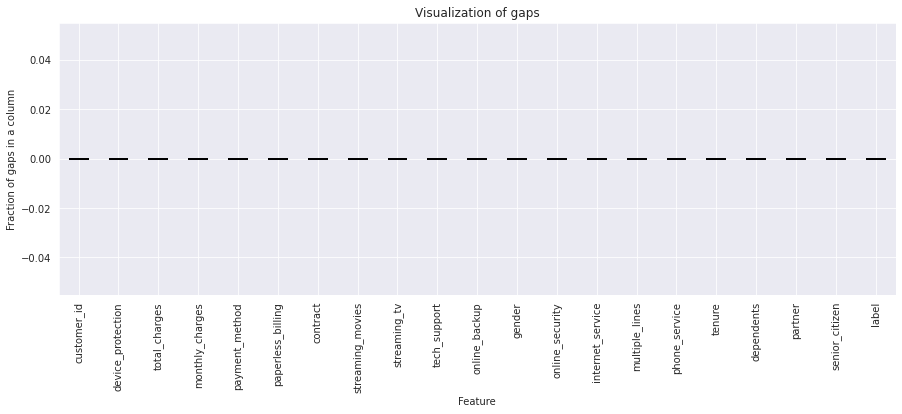

In [22]:
df.isna().mean().sort_values(ascending=False).plot(
    kind='bar', figsize=(15,5), 
    grid=True, color='steelblue', 
    edgecolor='black', linewidth=2
)
plt.title('Visualization of gaps')
plt.xlabel('Feature')
plt.ylabel('Fraction of gaps in a column')
plt.show()

We have no missing values

The features are categorical, we will encode in the future - `OrdinalEncoder` for ordinal and` Ohe` for binary

Delete the `customer_id` feature

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

#### Pipe data processing

<a id='Pipe'></a>

To speed up work in the future, we will make training in the form of pipe methods
To do this, we will overwrite the variables of the sets and load them again - to demonstrate the effectiveness of this approach - in the future this can save time. We will do the preparation through the method queue

In [23]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,label
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [24]:
def col_name(data):
  data.reset_index(inplace=True)
  data.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'label']
  return data

def change_types_and_label(data):
  data.loc[data['total_charges'] == ' ', 'total_charges'] = data['monthly_charges']
  data['total_charges'] = data['total_charges'].astype('float64')
  data['senior_citizen'] = data['senior_citizen'].astype('category')
  data['loyality'] =  data['contract'].apply(lambda x: 0 if x == 'Month-to-month' else 1).astype('category')
  data['label'] = data['label'].apply(lambda x: 0 if x == 'No' else 1).astype('int64')
  data['multiple_lines'] = data['multiple_lines'].apply(lambda x: 'No' if x == 'No phone service' else x)
  cols = ['online_backup', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'online_security']
  for col in cols:
    data[col] = data[col].apply(lambda x: 'No' if x == 'No internet service' else x)
  return data

def fillnan(data):
  data['internet_service'] = data['internet_service'].apply(lambda x: 0 if x == 'No' else 1).astype('category')
  return data

def drop_cols(data):
  cols = ['customer_id']
  data.drop(cols, inplace=True, axis=1)
  return data

In [25]:
df = (pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col='customerID')
    .pipe(col_name)
    .pipe(change_types_and_label)
    .pipe(fillnan)
    .pipe(drop_cols)
)

In [26]:
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,label,loyality
0,Female,0,Yes,No,1,No,No,1,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,Male,0,No,No,34,Yes,No,1,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1
2,Male,0,No,No,2,Yes,No,1,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0
3,Male,0,No,No,45,No,No,1,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1
4,Female,0,No,No,2,Yes,No,1,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             7043 non-null   object  
 1   senior_citizen     7043 non-null   category
 2   partner            7043 non-null   object  
 3   dependents         7043 non-null   object  
 4   tenure             7043 non-null   int64   
 5   phone_service      7043 non-null   object  
 6   multiple_lines     7043 non-null   object  
 7   internet_service   7043 non-null   category
 8   online_security    7043 non-null   object  
 9   online_backup      7043 non-null   object  
 10  device_protection  7043 non-null   object  
 11  tech_support       7043 non-null   object  
 12  streaming_tv       7043 non-null   object  
 13  streaming_movies   7043 non-null   object  
 14  contract           7043 non-null   object  
 15  paperless_billing  7043 non-null   object  
 16  paymen

Thus, when repeating the study - you can quickly get a set for work - `object` or` category` did not begin to be converted to the same format - there is no need - the data will be loaded into the model via `Pipeline`

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

## Exploratory data analysis

### Traits monthly_charges and total_charges

Let's consider separately the signs that are responsible for customer payments - `monthly_charges` and` total_charges`

In [28]:
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,label,loyality
0,Female,0,Yes,No,1,No,No,1,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,Male,0,No,No,34,Yes,No,1,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1
2,Male,0,No,No,2,Yes,No,1,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0
3,Male,0,No,No,45,No,No,1,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1
4,Female,0,No,No,2,Yes,No,1,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0


In [29]:
cols = ['monthly_charges', 'total_charges']

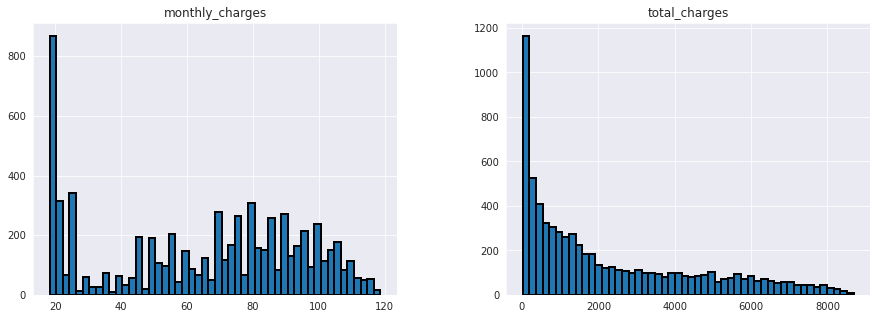

In [30]:
df[cols].hist(bins=50, figsize=(15,5), edgecolor='black', linewidth=2)
plt.show()

The more users pay per month, the higher the likelihood of leaving, in other words, the most profitable customers leave for an unknown reason

In [31]:
df[['monthly_charges', 'total_charges']].describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2279.798992,2266.730170,18.80,398.55,1394.55,3786.60,8684.80


`total_charges` is strongly skewed to the right, we observe a long tail

In [32]:
df.groupby('label')['monthly_charges'].agg('mean')

label
0    61.265124
1    74.441332
Name: monthly_charges, dtype: float64

Let's check how the average monthly total payments of customers that left and those who remained are different
Let us construct hypotheses: Let us formulate it as a hypothesis about the equality of the means of two general populations

**H0 (null hypothesis): Average user payments are equal.**

**H1 (alternative hypothesis): Average user payments are not equal.**

In [33]:
df_churn = df.query('label == 1')
df_clients = df.query('label == 0')


sample_1 = df_churn['monthly_charges'][df_churn['monthly_charges'].notna()].tolist()
sample_2 = df_clients['monthly_charges'][df_clients['monthly_charges'].notna()].tolist()
alpha = .05
stat, p = stats.levene(sample_1, sample_2)
result_levene = p



if result_levene < alpha:
    print('Reject H0, variances differ')
else:
    print('We do not reject H0, variances do not differ')

var_sample = [np.var(x, ddof=1) for x in [sample_1, sample_2]]
print('Sample variances: ', var_sample)

Reject H0, variances differ
Sample variances:  [608.4141833954307, 966.7527670734264]


In [34]:
alpha = .05 
results = stats.mannwhitneyu(sample_1, sample_2, alternative='two-sided')

print('p-VALUE:', results.pvalue)

if results.pvalue < alpha:
    print("Reject Н0")
else:
    print("Do not reject Н0")

p-VALUE: 3.311627651988585e-54
Reject Н0


Thus, we confirm that the average monthly payments of those who left are not equal. Those who leave - pay more

Let's look at the QQ-graph of our features and at kde

In [35]:
def qq_plt(data):
  measurements = data
  stats.probplot(measurements, dist="norm", plot=pylab)
  plt.title('QQ-plot')
  plt.xlabel('Theoretical quantiles')
  plt.ylabel('Ordered values')
  pylab.show()

def kde_plot(data, col):
  plt.figure(figsize=(10,5))
  sns.kdeplot(data=data, shade=True, 
                 alpha=.5, linewidth=4.2
  )
  plt.xlabel(f"{col}")
  plt.title('KDE')
  plt.show()

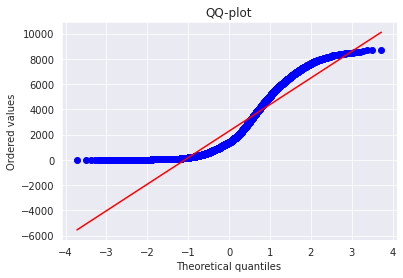

In [36]:
qq_plt(df['total_charges'])

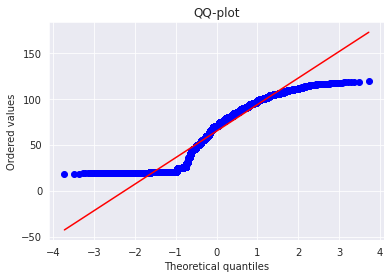

In [37]:
qq_plt(df['monthly_charges'])

The nature of our features is far from normally distributed

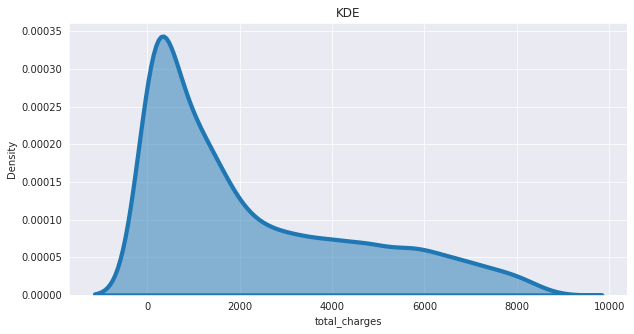

In [38]:
kde_plot(df['total_charges'], 'total_charges')

Observe the long tail on the right, the distribution is asymmetric, skewed to the right

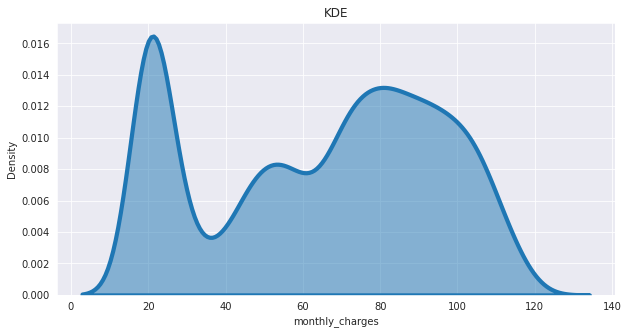

In [39]:
kde_plot(df['monthly_charges'], 'monthly_charges')

Let's add a payment sign - if a client pays for a year in advance - we will consider this a sign of loyalty. We also added this feature to the pipe of the set preparation

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### Exploring of the dependence of care on various traits

Let's see and study the properties of a user who leaves the company

In [40]:
def plot_hist(data, col):
  plt.figure(figsize=(12,6))
  data[col].hist(ec='black', alpha=0.84)
  data[data['label'] == 1][col].hist(ec='black', alpha=0.84)
  plt.legend(['All users', 'Churn users'])
  plt.xticks(rotation=42)
  plt.title(f"Churn on feature {col}")
  plt.ylabel('Quantity of users')
  plt.show()

In [41]:
(df.groupby('payment_method')['label'].agg(['sum', 'count'])
.assign(ratio = lambda x: x['sum'] / x['count'])
).sort_values(by='ratio', ascending=False).style.background_gradient(low=0.42)

,sum,count,ratio
payment_method,,,
Electronic check,1071,2365,0.452854
Mailed check,308,1612,0.191067
Bank transfer (automatic),258,1544,0.167098
Credit card (automatic),232,1522,0.152431


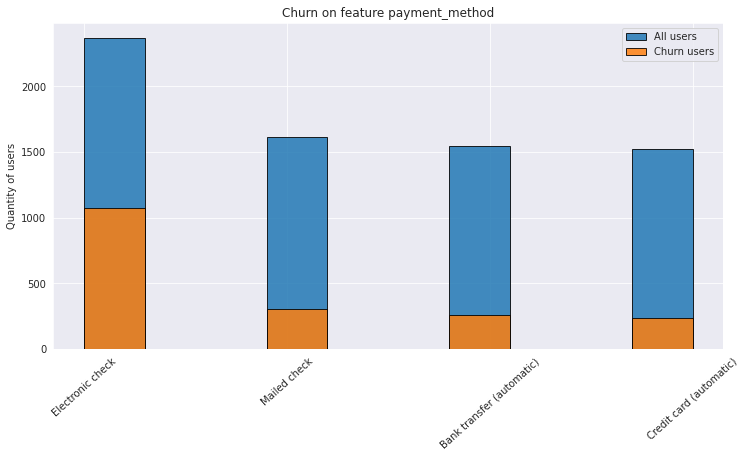

In [42]:
plot_hist(df, 'payment_method')

Most of users choose electronic checks, more than `45%` of customers who left - used this type of invoice receipt and interaction

In [43]:
(df.groupby('gender')['label'].agg(['sum', 'count'])
.assign(ratio = lambda x: x['sum'] / x['count'])
).sort_values(by='ratio', ascending=False).style.background_gradient(low=0.42)

,sum,count,ratio
gender,,,
Female,939,3488,0.269209
Male,930,3555,0.261603


Care does not depend on gender, at least not explicitly. The sample turned out to be quite balanced, the strata were observed, the number of men and the number of women were approximately the same - this is good for us.

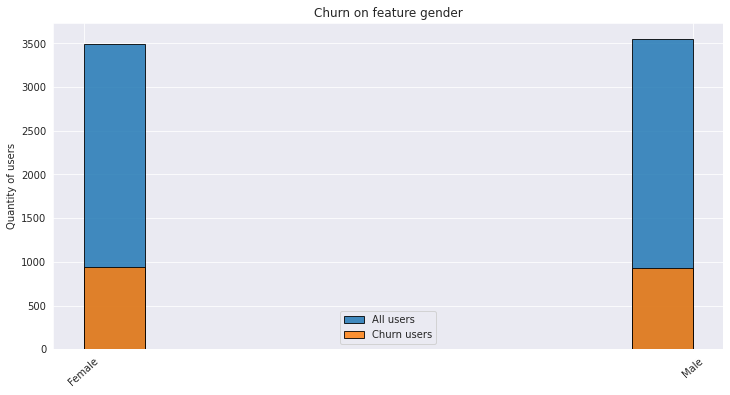

In [44]:
plot_hist(df, 'gender')

In [45]:
(df.groupby('contract')['label'].agg(['sum', 'count'])
.assign(ratio = lambda x: x['sum'] / x['count'])
).sort_values(by='ratio', ascending=False).style.background_gradient(low=0.42)

,sum,count,ratio
contract,,,
Month-to-month,1655,3875,0.427097
One year,166,1473,0.112695
Two year,48,1695,0.028319


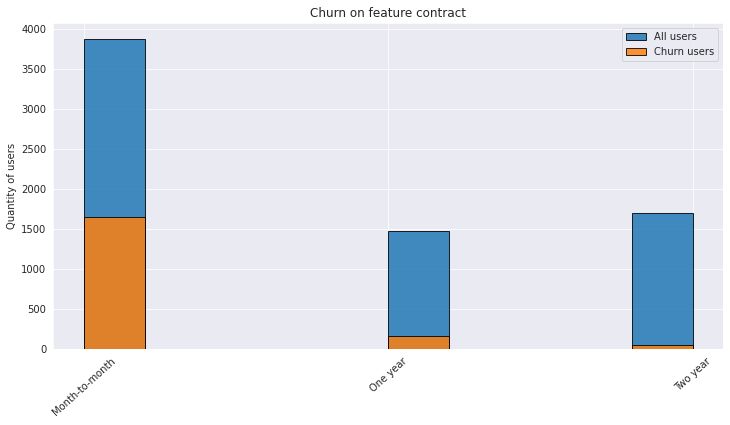

In [46]:
plot_hist(df, 'contract')

Users with monthly subscriptions are more likely to leave than those who prefer long-term contracts

In [47]:
(df.groupby('internet_service')['label'].agg(['sum', 'count'])
.assign(ratio = lambda x: x['sum'] / x['count'])
).sort_values(by='ratio', ascending=False).style.background_gradient(low=0.42)

,sum,count,ratio
internet_service,,,
1,1756,5517,0.318289
0,113,1526,0.074050


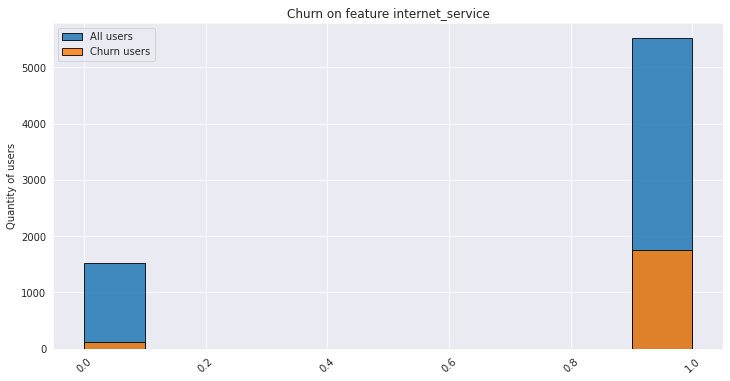

In [48]:
plot_hist(df, 'internet_service')

Fiber optic users are more likely to churn

For the rest of the criteria, we will go through using only histograms.

In [49]:
def plot_hist_groups(data, cols, n_cols):

  fig, ax = plt.subplots(nrows=1, ncols=n_cols, figsize = (15,4))
  for i, col in enumerate(cols):

      ax[i].hist(data[col], ec='black', alpha=0.84)
      ax[i].hist(data[data['label'] == 1][col], ec='black', alpha=0.84)
      ax[i].set_title(f"Churn on feature {col}")
      ax[i].legend(['All users', 'Churn users'])

  plt.ylabel('Quantity of users')
  fig.autofmt_xdate()
  plt.tight_layout()
  plt.show()

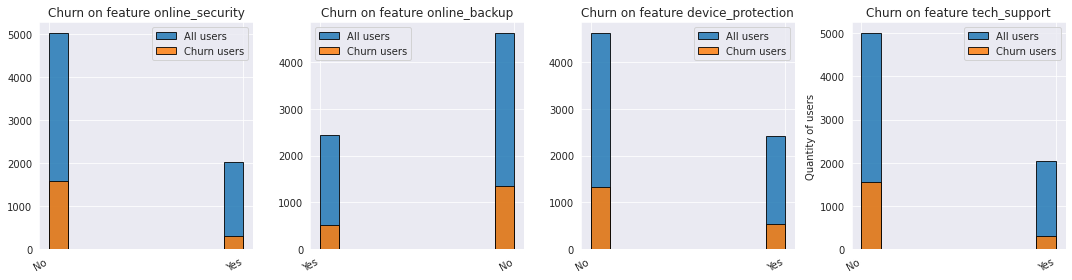

In [50]:
cols = ['online_security', 'online_backup', 'device_protection', 'tech_support']
plot_hist_groups(df, cols, 4)

Most often, users who do not use the services leave: `online_security`,` online_backup`, `tech_support` and` device_protection`

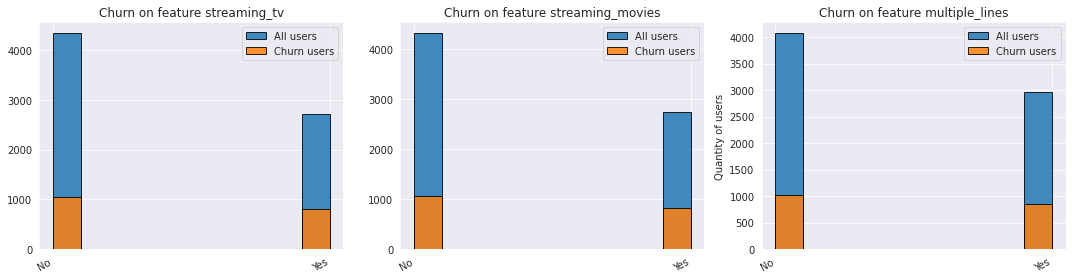

In [51]:
cols = ['streaming_tv', 'streaming_movies', 'multiple_lines']
plot_hist_groups(df, cols, 3)


With streaming services, not everything is so simple. Users using the services and not leaving are almost the same. Likewise for those users who use multiple lines

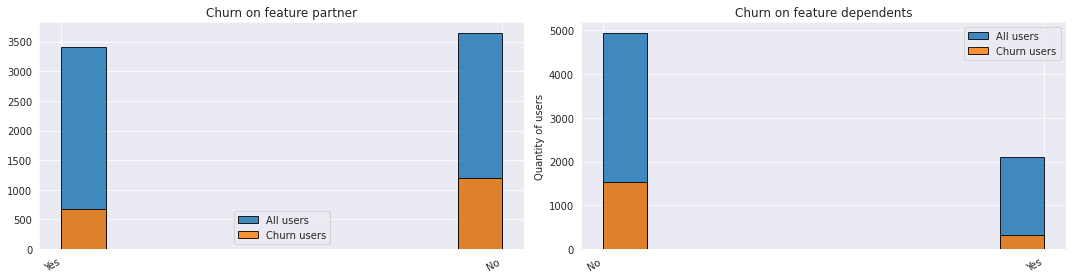

In [52]:
cols = ['partner', 'dependents']
plot_hist_groups(df, cols, 2)

Users who are not married are more likely to leave than those who are in a legal relationship. It is also worth noting that users who are dependents are less likely to leave the company - they do not choose, they choose for them

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### Checking for multicollinearity and mutual information

At the final stage of data preparation, we will check the multicollinearity between our numerical data. If the value exceeds 0.8 - a strong correlation - we will get rid of unnecessary features to improve generalization. Let's use Pearson's Correlation and [Phik-correlation](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7) - quite new, but capable, as stated, to eliminate dependencies in nonlinear connections. We will also check the mutual information of categorical features. Let's prepare our data:

In [53]:
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,label,loyality
0,Female,0,Yes,No,1,No,No,1,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,Male,0,No,No,34,Yes,No,1,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1
2,Male,0,No,No,2,Yes,No,1,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0
3,Male,0,No,No,45,No,No,1,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1
4,Female,0,No,No,2,Yes,No,1,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0


In [54]:
corr_check = df[['monthly_charges', 'total_charges', 'tenure']].copy()

In [55]:
plot_values = df[['monthly_charges', 'total_charges', 'tenure', 'label']].copy()

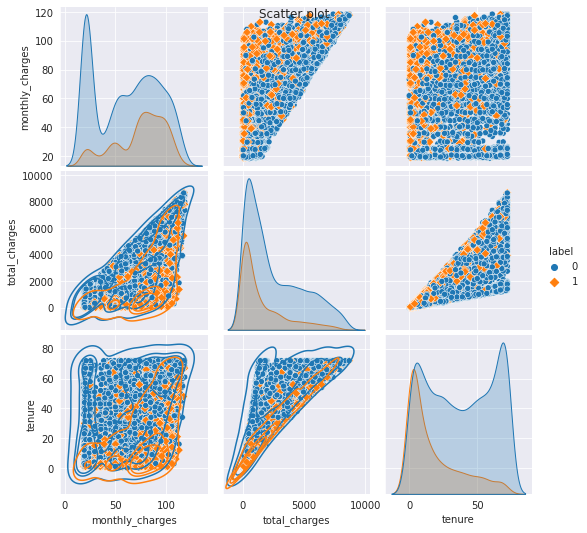

In [56]:
map_corr = sns.pairplot(plot_values, hue='label', markers=["o", "D"])
(map_corr.map_lower(sns.kdeplot, levels=4, color=".1")
.fig.suptitle('Scatter plot'))
plt.show()

The diagram shows the dependence between the traits `total_charges` and` month_charges` and a strong one between `total_charges` and` tenure`. Let's see the correlation coefficients

#### Pearson Correlation

In [57]:
corr_check.corr(method='pearson')

,monthly_charges,total_charges,tenure
monthly_charges,1.000000,0.651182,0.247900
total_charges,0.651182,1.000000,0.826164
tenure,0.247900,0.826164,1.000000


#### Phik Correlation

In [58]:
phik_overview = corr_check.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'tenure']


,monthly_charges,total_charges,tenure
monthly_charges,1.00,0.76,0.41
total_charges,0.76,1.00,0.84
tenure,0.41,0.84,1.00


A strong correlation is observed in two signs - `tenure` and` total_charges` - we will remove `total_charges` - we will get it from days and monthly payment

#### Mutual information


Now let's turn to mutual information. To do this, we translate our categorical signs to human ones using coding:

In [59]:
X = df.copy()
y = X.pop('label')

for col in list(X.select_dtypes(['object', 'category']).columns):
    X[col], _ = X[col].factorize()

discrete_features = X.dtypes == int

The data has been transformed - we can see the mutual information:

In [60]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name='mutual_information оценка', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3].to_frame('Mi_scores')

,Mi_scores
contract,0.098453
payment_method,0.044519
internet_service,0.031370
tech_support,0.014608
senior_citizen,0.010577
streaming_tv,0.001981
phone_service,0.000072


Most of the information about the target attribute is contained in `tenure` and` payment_method`. But not so significant as to remove total_days from training

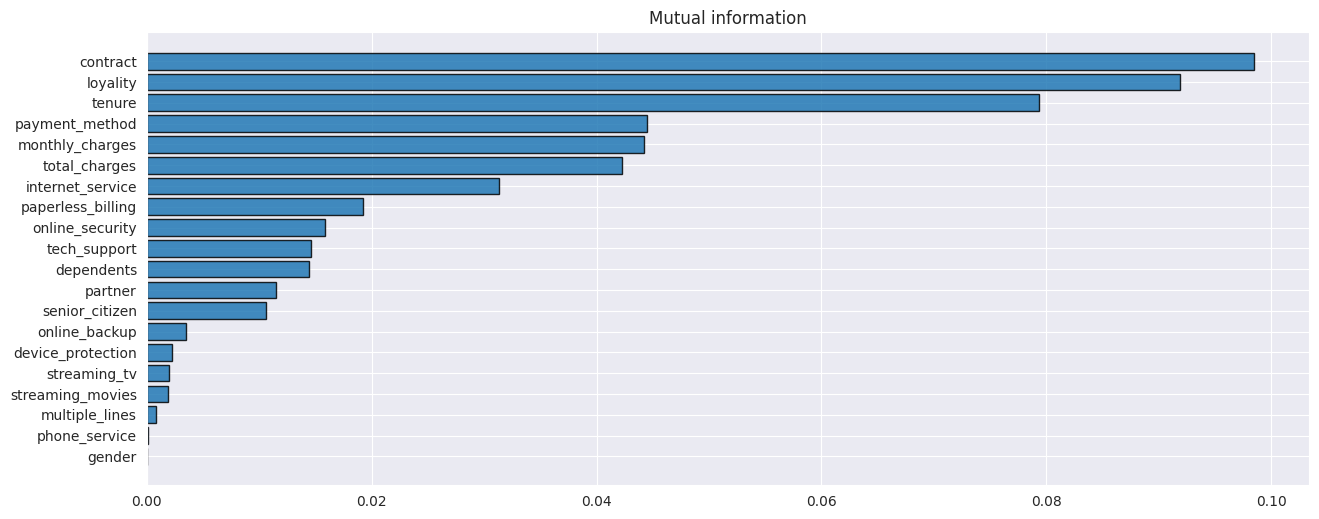

In [61]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, ec='black', alpha=0.84)
    plt.yticks(width, ticks)
    plt.title('Mutual information')


plt.figure(dpi=100, figsize=(15, 6))
plot_mi_scores(mi_scores)

In fact - the attribute `tenure` will determine the target to a greater extent. Without this feature, a ROC-AUC estimate of 0.87 was achieved. We will train with this attribute - it is calculated, the attribute `total_charges` will be removed from training. During the training, we will also look at the `features importance` of the models and compare with the research results

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

**Conclusions**


Most often those users leave the company who use:

- electronic checks
- use a monthly payment - here you can offer discounts for payment for a longer period
- do not use additional services in the form of antivirus, cloud storage, a dedicated line with technical support and equipment protection - perhaps these services should be included in offers for users as a recommendation (Internet security: antivirus (***DeviceProtection***) and blocking insecure sites (***OnlineSecurity***); dedicated technical support line (***TechSupport***); Cloud file storage for data backup (***OnlineBackup***)
- not married
- the higher the monthly payment, the higher the likelihood of leaving. It may be worth considering the need for incentives to move to better rates.

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

In [62]:
print('Features for training model and target label')
print('___________________________')
for col in list(df.columns):
  print(col)

Features for training model and target label
___________________________
gender
senior_citizen
partner
dependents
tenure
phone_service
multiple_lines
internet_service
online_security
online_backup
device_protection
tech_support
streaming_tv
streaming_movies
contract
paperless_billing
payment_method
monthly_charges
total_charges
label
loyality


In [63]:
df['label'].value_counts(normalize=True).to_frame('Class balance')

,Class balance
0,0.73463
1,0.26537


1. At the first stage, we prepared and worked out the `pipeline` for the preparation of features. In the future, it is possible to automate downloads using the `chaining` methods provided by` Pandas`

2. We have a class imbalance. There will be no clarifications about the importance of this or that class - we will predict with a standard threshold of `0.5`, while using the stratified selection method and the prediction method for cross-validation. I plan to use boosting model `XGboost`,` Catboost`, `LightGBM`, stacking based on models from support vector family, random forest and Logistic regression` SKlearn` with meta learner based on `Keras` model, shallow. I plan to select parameters `Optuna`

3. We plan to use StandardScaler for quantitative features in order to give them the same scale and normal shape

4. For categorical features I plan to use `OrdinalEncoder`. It was planned to use `OneHotEncoder` for binaries (` Yes-No`) - but it was decided to fill in the gaps with the value `No`

5. These transformations will be performed through the `Pipeline`. Let's measure the training and prediction times. Let's compare different models and draw conclusions

## Preparing data for training

Divide the sample into training and test samples

In [64]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

In [65]:
features, target = split_data(df, 'label')
features.shape, target.shape

((7043, 20), (7043,))

In [66]:
X_train , X_test , y_train , y_test, = train_test_split ( 
                                features, target, test_size=0.25, random_state=42)


In [67]:
X_train.shape[0] + X_test.shape[0]

7043

In [68]:
y_train.shape, y_test.shape

((5282,), (1761,))

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

#### Clustering and finding the optimal number of clusters for `monthly_charges` and` total_charges`

Let's add an additional feature - a cluster for the monthly payment of the client

In [69]:
optimal_clusters = X_train[['monthly_charges', 'total_charges']]

The optimal number of clusters will be selected using the elbow method

In [70]:
distortion = []
K = range(1, 8)
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(optimal_clusters)
    distortion.append(model.inertia_) 

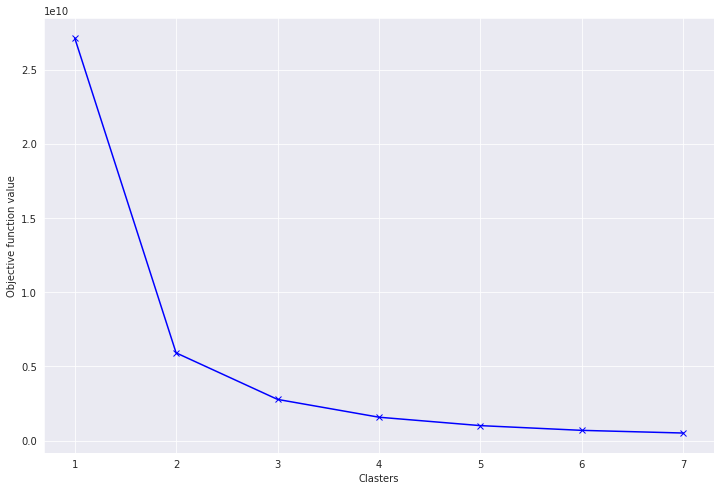

In [71]:
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Clasters')
plt.ylabel('Objective function value')
plt.show() 

Let's see our target groups:

In [72]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(optimal_clusters)
print("Typical segment users for 3 clusters:")
print(np.round(model.cluster_centers_))

Typical segment users for 3 clusters:
[[  50.  686.]
 [  78. 3279.]
 [  98. 6290.]]


Centroids


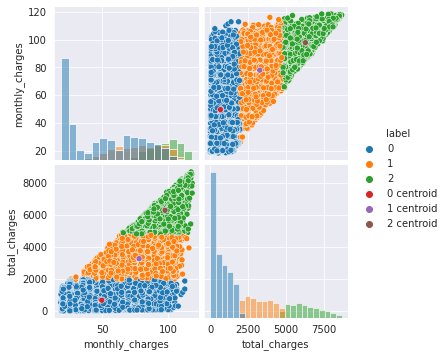

In [73]:
print('Centroids')
centroids = pd.DataFrame(model.cluster_centers_, columns=optimal_clusters.columns)
optimal_clusters['label'] = model.labels_.astype(str)
centroids['label'] = ['0 centroid', '1 centroid', '2 centroid']
data_cluster = pd.concat([optimal_clusters, centroids], ignore_index=True)
sns.pairplot(data_cluster, hue='label', diag_kind='hist')
plt.show()


Let's focus on three clusters

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

## Pipeline preprocessing

`Pipeline` will consist of the following components:

1. `StandardScaler` for numeric features
2. `OrdinalEncoder` for ordinal features
3. `OneHotEncoder` for binary signs
4. `Kmean` to create an additional feature in the form of a cluster
5. `delete_cols_array` to remove auxiliary signs from `np.ndarray`

In [74]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6607 to 860
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             5282 non-null   object  
 1   senior_citizen     5282 non-null   category
 2   partner            5282 non-null   object  
 3   dependents         5282 non-null   object  
 4   tenure             5282 non-null   int64   
 5   phone_service      5282 non-null   object  
 6   multiple_lines     5282 non-null   object  
 7   internet_service   5282 non-null   category
 8   online_security    5282 non-null   object  
 9   online_backup      5282 non-null   object  
 10  device_protection  5282 non-null   object  
 11  tech_support       5282 non-null   object  
 12  streaming_tv       5282 non-null   object  
 13  streaming_movies   5282 non-null   object  
 14  contract           5282 non-null   object  
 15  paperless_billing  5282 non-null   object  
 16  paym

Let's compose lists of features for processing in `Pipeline`

In [75]:
cluster_cols = ['monthly_charges', 'total_charges']
num_features = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
cat_features = ['payment_method', 'contract']
binary_features = list(set(list(X_train.select_dtypes(exclude=['int64', 'float64']).columns)) - set(cat_features) - set(['internet_service']))

In [76]:
X_train , X_test , y_train , y_test, = train_test_split ( 
                                features, target, test_size=0.25, random_state=42)



Let's create a helper class for `KMeans` and a function to remove unnecessary features - in order to demonstrate how` Pipeline` works

In [77]:
class AttributAdder(BaseEstimator, TransformerMixin):

    
    def __init__(self, attr = True):
        self.attr = attr

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        kmeans = KMeans(n_clusters=3, random_state=42)
        X['cluster'] = kmeans.fit_predict(X)
        X['cluster'] = X['cluster'].astype("category")
        
        return X

In [78]:
def delete_cols_array(X):
    arr = np.array([1, 19, 20])
    X = np.delete(X, arr, 1)
    return X



def return_DF(X):
    cols = (['monthly_charges', 'tenure'] + 
            cat_features +  
            binary_features +
            ['cluster'])

    X = pd.DataFrame(X, columns=cols)
    cols_type = (cat_features +  
                binary_features +
                ['cluster'])
    for col in cols:
         X[col] = X[col].astype('float64')
    return X    

Create a `Pipeline`

In [79]:
preprocessor = ColumnTransformer (
    transformers = [
        
        ('std_scaler' , StandardScaler() , num_features) ,
        ('cat' , OrdinalEncoder() , cat_features) ,
        ('binary' , OneHotEncoder(drop='first') , binary_features),
        ('kmeans', AttributAdder(), cluster_cols),
        
        ]
)

pipe = Pipeline(steps=
    
    [
     ('preprocessor', preprocessor),
     ('delete_cols_array', FunctionTransformer(delete_cols_array, validate=False)),
     ('return_DF', FunctionTransformer(return_DF, validate=False))

     ]
)


In [80]:
X_train.shape

(5282, 20)

In [81]:
X_train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,loyality
6607,Male,0,No,Yes,1,No,No,1,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,25.30,25.30,0
2598,Female,0,No,No,7,Yes,No,1,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,75.15,525.00,0
2345,Female,0,No,Yes,4,Yes,No,0,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),20.05,85.50,0
4093,Female,0,No,No,29,Yes,Yes,1,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),76.00,2215.25,0
693,Female,0,No,No,3,Yes,Yes,1,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),75.10,270.70,0


In [82]:
X_train_prep = pipe.fit_transform(X_train)

In [83]:
X_train_prep.head()

,monthly_charges,tenure,payment_method,contract,streaming_movies,online_security,senior_citizen,streaming_tv,multiple_lines,gender,partner,paperless_billing,phone_service,dependents,device_protection,online_backup,tech_support,loyality,cluster
0,-1.282882,-0.997110,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.037857,-0.776834,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-1.160369,-0.970572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.139429,-0.031744,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.201207,-0.888933,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Check the functionality of the `Pipeline`

In [84]:
X_train_prep.shape

(5282, 19)

We got the expected result - the output is a transformed `DataFrame Pandas` - this will allow us to use` iloc`, which we need when training models. We can start preparing the models. Let's create auxiliary tables for preparing the report

In [85]:
auc = []
accuracy = []
training_time = []
prediction_time = []
model_name = []

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### XGboost base with transforms

Since we have an imbalance of classes, it is necessary to take this into account in training. We will weigh the target variables during training. We will also try various ensemble methods - cross-validation, stacking, voting and upsampling.

In [86]:
y_train.value_counts(normalize=True).to_frame('Calss balance')

,Calss balance
0,0.736842
1,0.263158


Let's prepare a test set using `Pipline`, then select a validation set for our model

In [87]:
X_test_prep = pipe.transform(X_test)

In [88]:
X_train_prep.shape, X_test_prep.shape, y_train.shape, y_test.shape

((5282, 19), (1761, 19), (5282,), (1761,))

In [89]:
X, X_val, y, y_val = train_test_split(X_train_prep, y_train, test_size=0.2,
                                      random_state=42)

Train the model

In [90]:
%%time
start = time.time()

classes_weights = class_weight.compute_sample_weight(
                  class_weight='balanced',
                  y = y_train)
model = XGBClassifier(sample_weight=classes_weights,
                                    random_state=42,
                                    eval_metric ='logloss')
model.fit(X, y, eval_set = [(X_val, y_val)],
              early_stopping_rounds=200, verbose=50)

end = time.time()
elapsed = end - start

[10:15:22] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.58862
[50]	validation_0-logloss:0.45446
[99]	validation_0-logloss:0.48477
CPU times: user 1.44 s, sys: 13 ms, total: 1.45 s
Wall time: 399 ms


In [91]:
start_pred = time.time()
y_pred = model.predict_proba(X_test_prep)[:, 1]
end_pred = time.time()
elapsed_pred = end_pred - start_pred

y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
auc.append(roc_auc_score(y_test, y_pred))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(model.__class__.__name__)+str(' ')+str('базовый')))

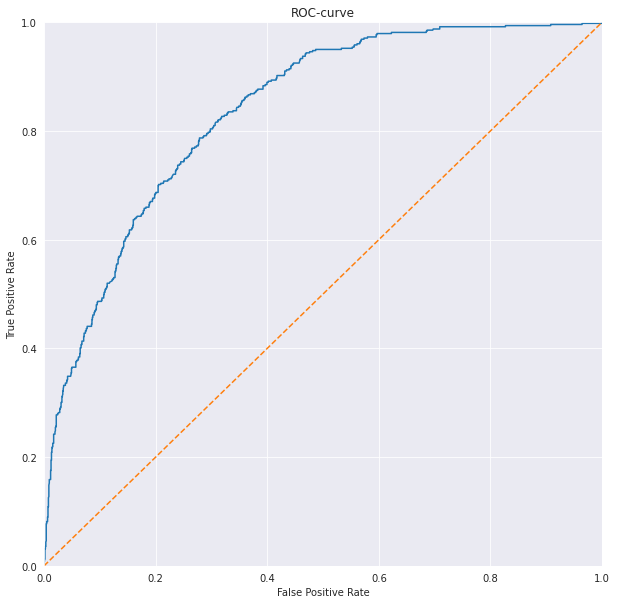

AUC: 0.8368187754650063


In [92]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred))

We got a fairly high result - satisfying the required quality. Let's try to improve it with the help of predictions on `StratifiedFolds` and tuning parameters

But first let's try to look at the `PR` curve

[10:15:23] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.58862
[50]	validation_0-logloss:0.45446
[99]	validation_0-logloss:0.48477
Threshold = 0.00 | Precision = 0.272, Recall = 1.000 | F1-score = 0.428
Threshold = 0.05 | Precision = 0.381, Recall = 0.973 | F1-score = 0.548
Threshold = 0.10 | Precision = 0.424, Recall = 0.948 | F1-score = 0.585
Threshold = 0.15 | Precision = 0.450, Recall = 0.894 | F1-score = 0.598
Threshold = 0.20 | Precision = 0.474, Recall = 0.850 | F1-score = 0.608
Threshold = 0.25 | Precision = 0.505, Recall = 0.793 | F1-score = 0.617
Threshold = 0.30 | Precision = 0.532, Recall = 0.737 | F1-score = 0.618
Threshold = 0.35 | Precision = 0.561, Recall = 0.685 | F1-sc

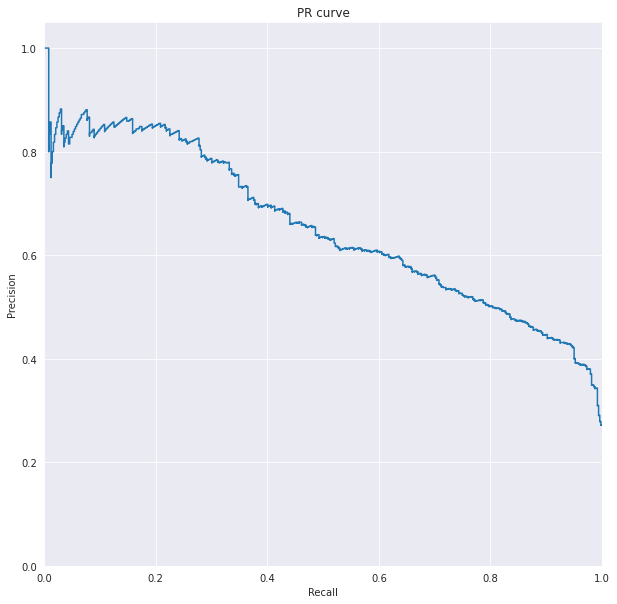

In [93]:
classes_weights = class_weight.compute_sample_weight(
                  class_weight='balanced',
                  y = y_train)
model = XGBClassifier(sample_weight=classes_weights,
                                    random_state=42,
                                    eval_metric ='logloss')
model.fit(X, y, eval_set = [(X_val, y_val)],
              early_stopping_rounds=200, verbose=50)
probabilities_valid = model.predict_proba(X_test_prep)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(y_test, predicted_valid)
    recall = recall_score(y_test, predicted_valid)
    f1 = f1_score(y_test, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(y_test, probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

For a threshold of 0, the completeness is 1 - all answers are positive. At the threshold of `0.85`, the model stops giving correct answers. The highest indicator `F1` is observed with the threshold` 0.35-0.40`. In the future, we will look at the `ROC-AUC` curve and` AUC` - there have been no clarifications on the importance of the classes. Let's look at the importance of signs.

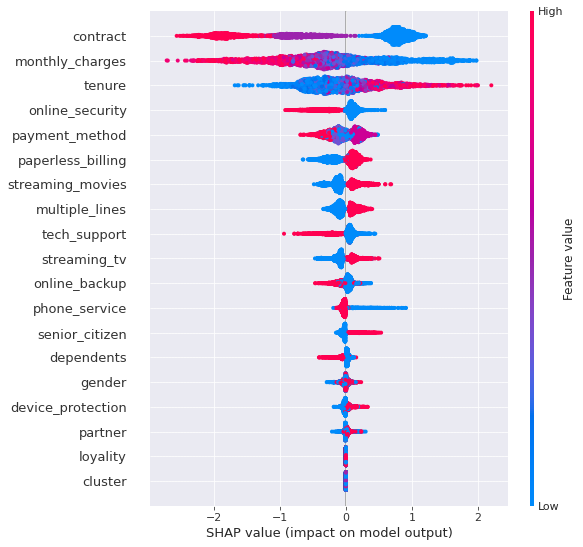

In [94]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

The data confirms our findings in the `EDA`:


Most often those users leave the company who use:
short-term contracts
electronic checks
use a monthly payment
do not use additional services in the form of antivirus, cloud storage, dedicated line with technical support and equipment protection

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### LightGBM с GridSearch

Let's try `LGBM` through` GridSearchCV` from `sklearn` - select the best parameters and see the results

In [95]:
%%capture
train_X = features.copy()
train_X.drop('total_charges', axis=1, inplace=True)

In [96]:
X_train , X_test , y_train , y_test, = train_test_split ( 
                                train_X, target, test_size=0.25, random_state=42)

In [97]:
cat_features_light = list(X_train.select_dtypes(include=['object', 'category']))

In [98]:
len(cat_features_light)

17

`LGBM` works better and faster without` Ohe` and `Ordinal` coding. Therefore, we will transform our samples for `LGBM` - we will translate everything into` category` except numeric

In [99]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()
X_train_lgbm[cat_features_light] = (X_train[cat_features_light]
                                    .apply(lambda x: x.astype('category')))
X_test_lgbm[cat_features_light] = (X_test[cat_features_light]
                                   .apply(lambda x: x.astype('category')))

In [100]:
X_train_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6607 to 860
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             5282 non-null   category
 1   senior_citizen     5282 non-null   category
 2   partner            5282 non-null   category
 3   dependents         5282 non-null   category
 4   tenure             5282 non-null   int64   
 5   phone_service      5282 non-null   category
 6   multiple_lines     5282 non-null   category
 7   internet_service   5282 non-null   category
 8   online_security    5282 non-null   category
 9   online_backup      5282 non-null   category
 10  device_protection  5282 non-null   category
 11  tech_support       5282 non-null   category
 12  streaming_tv       5282 non-null   category
 13  streaming_movies   5282 non-null   category
 14  contract           5282 non-null   category
 15  paperless_billing  5282 non-null   category
 16  paym

In [101]:
model = LGBMClassifier(random_state=42, class_weight = 'balanced')

In [102]:
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
params_space = {'n_estimators': [500, 1000],
                  'learning_rate': [0.01, 0.4],
                  'max_depth': [10, 25],
                  'num_leaves':[31, 40, 60]}

grid_cv = GridSearchCV(model, params_space, scoring='roc_auc', cv=cv)
grid_cv.fit(X_train_lgbm, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             estimator=LGBMClassifier(class_weight='balanced', random_state=42),
             param_grid={'learning_rate': [0.01, 0.4], 'max_depth': [10, 25],
                         'n_estimators': [500, 1000],
                         'num_leaves': [31, 40, 60]},
             scoring='roc_auc')

In [103]:
grid_cv.best_params_

{'learning_rate': 0.01, 'max_depth': 25, 'n_estimators': 500, 'num_leaves': 31}

In [104]:
estimator = grid_cv.best_estimator_

In [105]:
start_pred = time.time()
y_pred = estimator.predict_proba(X_test_lgbm)[:, 1]
end_pred = time.time()
elapsed_pred = end_pred - start_pred

y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
auc.append(roc_auc_score(y_test, y_pred))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str('LightGBM')+str(' ')+str('GridSearCVcategory')))

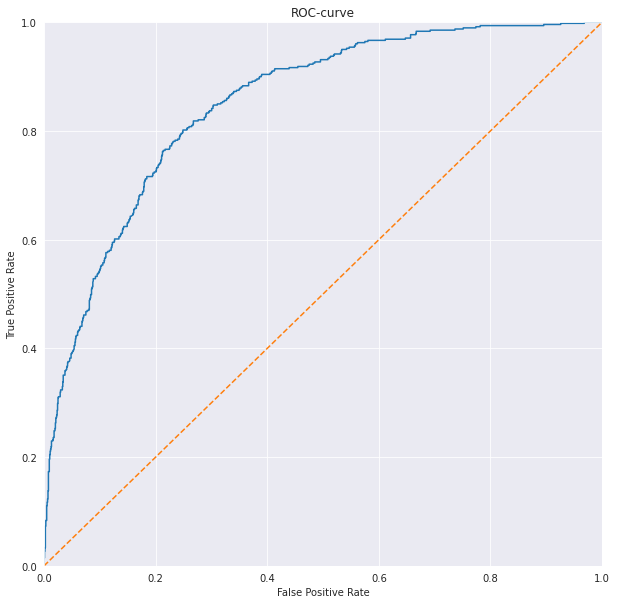

AUC: 0.8500980331488834


In [106]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred))

The result is quite high. let's see other models and at the end we will make a conclusion

In [107]:
fi = (pd.DataFrame({'feature': list(X_train.columns), 
                    'importance': estimator.feature_importances_})
.sort_values(by='importance', ascending=False))

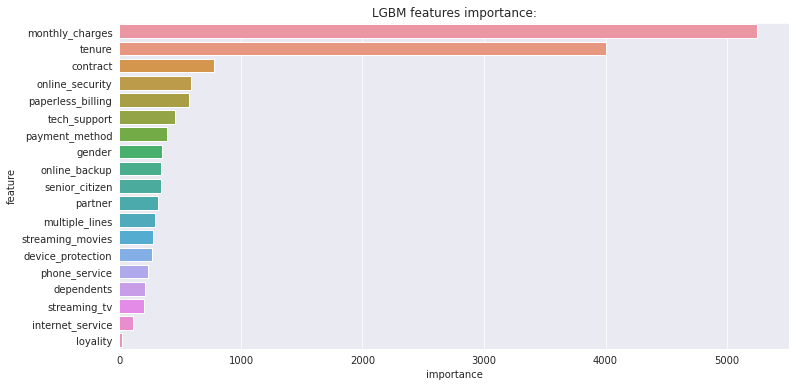

In [108]:
plt.figure(figsize=(12, 6));
sns.barplot(x="importance", y="feature", data=fi);
plt.title('LGBM features importance:');

Signs of importance differ little from those used by `XGboost`

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### XGboost base with conversions with `cross_validate`,` cross_val_predict`

Let's try to check the performance of the model through `cross_validate` and` cross_val_predict` - this method will help to determine the possibility of using the model in the ensemble

In [109]:
%%time
start = time.time()

classes_weights = class_weight.compute_sample_weight(
                  class_weight='balanced',
                  y = y_train)

est = XGBClassifier(sample_weight=classes_weights,
                                    random_state=42,
                                    eval_metric ='logloss')

score = cross_validate(est, X_train_prep, y_train,
                           scoring=['roc_auc', 'accuracy'],
                           n_jobs=-1, verbose=0)
end = time.time()
elapsed = end - start
sorted(score.keys())

CPU times: user 52.9 ms, sys: 7.42 ms, total: 60.3 ms
Wall time: 1min 22s


['fit_time', 'score_time', 'test_accuracy', 'test_roc_auc']

In [110]:
score['test_accuracy']

array([0.79375591, 0.77388836, 0.77272727, 0.76704545, 0.76799242])

In [111]:
score['test_roc_auc']

array([0.83962791, 0.80071989, 0.80213053, 0.79814272, 0.81728653])

In [112]:
start_pred = time.time()
y_pred = cross_val_predict(est, X_train_prep, y_train, n_jobs=-1, 
                           verbose=0, method='predict_proba')[:, 1]
end_pred = time.time()
elapsed_pred = end_pred - start_pred

In [113]:
y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_train, y_bin))
auc.append(roc_auc_score(y_train, y_pred))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str('XGBClassifier')+str(' ')+str('sklearn CV')))

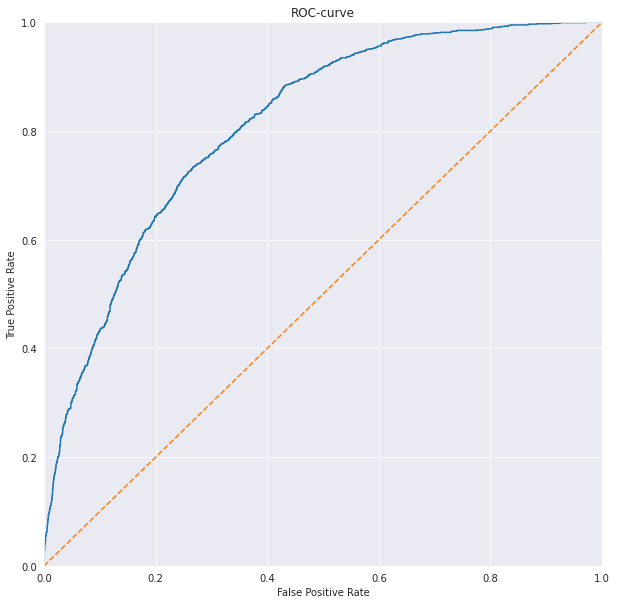

AUC: 0.8107299052844056


In [114]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_train, y_pred))

In what follows, we will use the manual prediction method for `Fold with CV`.

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### XGboost basic with cross-validated transforms

Let's try the same model, but we will make predictions with the help of `StratifiedKFold` - we get an ensemble of models

In [115]:
%%time

prediction = np.zeros(X_test_prep.shape[0])
n_fold = 5 
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42) 
rocauc_report = []
idx=0

for train_idx, test_idx in folds.split(X_train_prep, y_train):
    start = time.time()
    print("TRAIN:", len(train_idx), "TEST:", len(test_idx))
    X_train_fold, X_val_fold = X_train_prep.iloc[train_idx], X_train_prep.iloc[test_idx]
    y_tr_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
    classes_weights = class_weight.compute_sample_weight(
                      class_weight='balanced',
                      y = y_tr_fold)
    clone_clf = clone(XGBClassifier(sample_weight=classes_weights,
                                    random_state=42,
                                    eval_metric ='logloss'))
    clone_clf.fit(X_train_fold, y_tr_fold, eval_set = [(X_val_fold, y_val_fold)],
              early_stopping_rounds=200, verbose=50)
    y_pred = clone_clf.predict_proba(X_test_prep)[:, 1]
    prediction += y_pred
    rocauc_report.append(roc_auc_score(y_val_fold, clone_clf.predict_proba(X_val_fold)[:, 1], average ='macro'))
    print(idx+1, rocauc_report[idx])
    idx +=1

prediction /= n_fold
end = time.time()
elapsed = end - start

TRAIN: 4225 TEST: 1057
[10:21:12] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.58612
[50]	validation_0-logloss:0.44477
[99]	validation_0-logloss:0.46742
1 0.836792696779675
TRAIN: 4225 TEST: 1057
[10:21:12] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.58573
[50]	validation_0-logloss:0.44295
[99]	validation_0-logloss:0.46526
2 0.8376400291833287
TRAIN: 4226 TEST: 1056
[10:21:12] WARNING

In [116]:
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
training_time.append(elapsed)
prediction_time.append(elapsed)
model_name.append((str(clone_clf.__class__.__name__)+str(' ')+str('CV')))

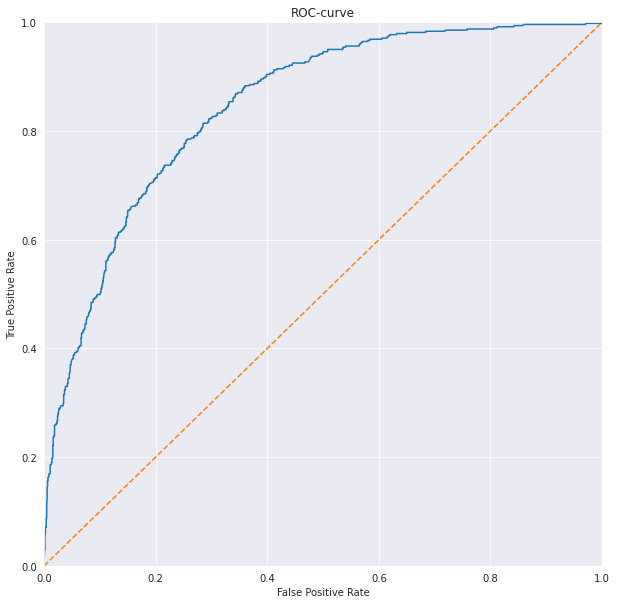

AUC: 0.8448820833835441


In [117]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred, average ='macro'))


The result is slightly better, but the model generalizes better. But in this case - it is better to use the base model - faster prediction times

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### Catboost basic without conversions

Let's try Catboost in the same way - first basic, then on `StratifiedFolds`

In [118]:
%%capture
train_X = features.copy()
train_X.drop('total_charges', axis=1, inplace=True)

In [119]:
X_train , X_test , y_train , y_test, = train_test_split ( 
                                train_X, target, test_size=0.25, random_state=42)

In [120]:
cat_features = list(X_train.select_dtypes(include=['object', 'category']).columns)

In [121]:
X, X_val, y, y_val = train_test_split(X_train, y_train, 
                                      test_size=0.2, random_state=42)

In [122]:
start = time.time()

train_data = Pool(data=X, 
                  label=y,
                  cat_features=cat_features)
valid_data = Pool(data=X_val, 
                  label=y_val,
                  cat_features=cat_features)
test_data = Pool(data=X_test,
                 cat_features=cat_features)

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 42
         }

model = CatBoostClassifier(**params)
model.fit(train_data,
          eval_set=valid_data, 
          use_best_model=True
          )
end = time.time()
elapsed = end - start

Learning rate set to 0.045236
0:	test: 0.8208916	best: 0.8208916 (0)	total: 64.5ms	remaining: 1m 4s
200:	test: 0.8486987	best: 0.8513108 (128)	total: 1.03s	remaining: 4.08s
400:	test: 0.8446824	best: 0.8513108 (128)	total: 2.07s	remaining: 3.1s
600:	test: 0.8402710	best: 0.8513108 (128)	total: 3.16s	remaining: 2.1s
800:	test: 0.8363111	best: 0.8513108 (128)	total: 4.27s	remaining: 1.06s
999:	test: 0.8334169	best: 0.8513108 (128)	total: 5.36s	remaining: 0us

bestTest = 0.8513107752
bestIteration = 128

Shrink model to first 129 iterations.


In [123]:
start_pred = time.time()
y_pred = model.predict_proba(X_test)[:, 1]

end_pred = time.time()
elapsed_pred = end_pred - start_pred

auc.append(roc_auc_score(y_test, y_pred, average ='macro'))
y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(model.__class__.__name__)+str(' ')+str('базовый')))

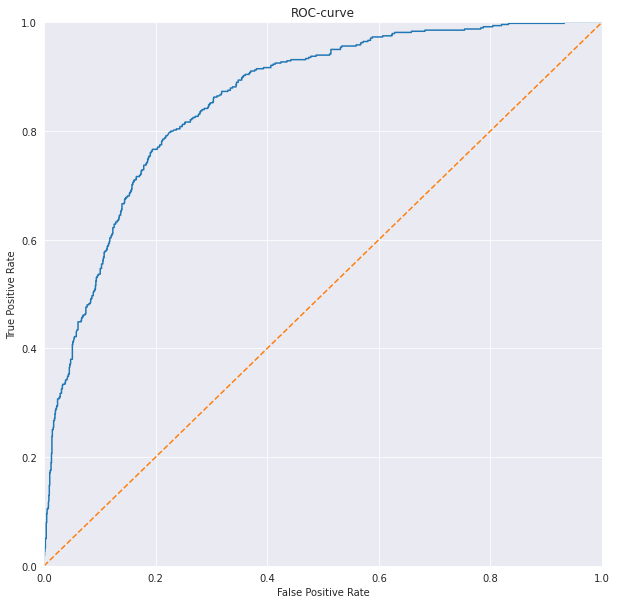

AUC: 0.8590765342513492


In [124]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred, average ='macro'))

`Catboost` shows better results than` XGboost` on this set and it does not require transformations for categorical features, which saves time

In [125]:
fi = model.get_feature_importance(prettified=True)

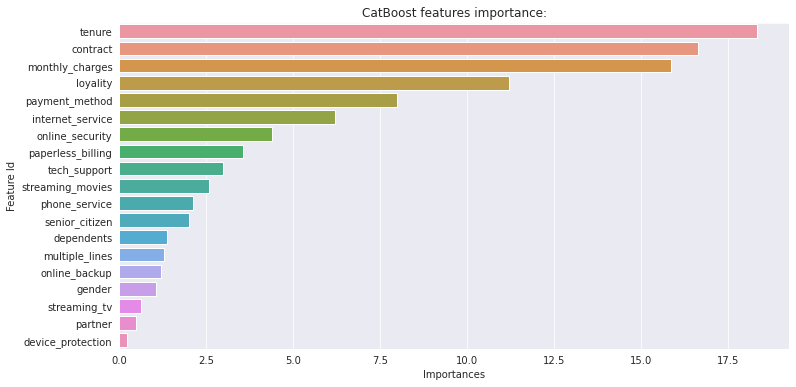

In [126]:
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=fi);
plt.title('CatBoost features importance:');

Let's save the most important features and try to build a model only on the basis of them in [later](#shap)

In [127]:
save_best = list(fi.loc[fi['Importances'] >= 1.5]['Feature Id'])

By features - everything is identical to `XGboost`, there are no striking changes

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### Catboost basic no cross-validated conversions

Let's see what results will be with `StratifiedKFold` in ensemble voting with cross-validation

In [128]:
%%time
start = time.time()

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

params_cat = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 42
         }

test_data = Pool(data=X_test,
                 cat_features=cat_features)
scores = []
prediction = np.zeros(X_test.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
    X_train_cat, X_valid_cat = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_cat, y_valid_cat = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_data = Pool(data=X_train_cat, 
                      label=y_train_cat,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params_cat)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
end = time.time()
elapsed = end - start

Learning rate set to 0.045236
0:	test: 0.8191049	best: 0.8191049 (0)	total: 5.85ms	remaining: 5.84s
200:	test: 0.8455408	best: 0.8463396 (161)	total: 1.11s	remaining: 4.41s
400:	test: 0.8410247	best: 0.8463396 (161)	total: 2.17s	remaining: 3.24s
600:	test: 0.8398519	best: 0.8463396 (161)	total: 3.22s	remaining: 2.14s
800:	test: 0.8389976	best: 0.8463396 (161)	total: 4.27s	remaining: 1.06s
999:	test: 0.8376770	best: 0.8463396 (161)	total: 5.33s	remaining: 0us

bestTest = 0.8463396164
bestIteration = 161

Shrink model to first 162 iterations.
Learning rate set to 0.045236
0:	test: 0.8147990	best: 0.8147990 (0)	total: 5.88ms	remaining: 5.87s
200:	test: 0.8496250	best: 0.8506178 (122)	total: 964ms	remaining: 3.83s
400:	test: 0.8488631	best: 0.8506178 (122)	total: 1.98s	remaining: 2.96s
600:	test: 0.8472285	best: 0.8506178 (122)	total: 3.03s	remaining: 2.01s
800:	test: 0.8451136	best: 0.8506178 (122)	total: 4.09s	remaining: 1.02s
999:	test: 0.8419967	best: 0.8506178 (122)	total: 5.17s	remai

In [129]:
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed)
model_name.append((str(model.__class__.__name__)+str(' ')+str('CV')))

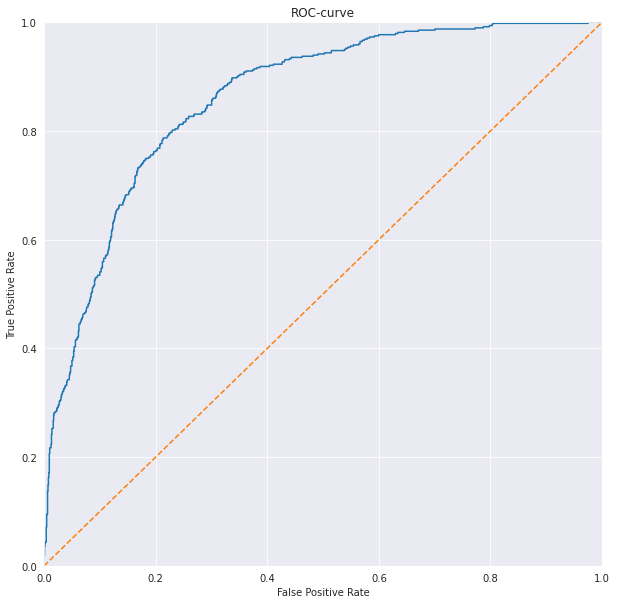

AUC: 0.8606659088910529


In [130]:
fpr, tpr, thresholds = roc_curve(y_test, prediction) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

We were able to improve the result, quite significantly

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### Xgboost tuning

Now let's try to set up the models. Let's start with `XGboost`, we will use the` Optuna` library

In [131]:
def objective(trial,data=X_train_prep,target=y_train):
    
    train_x, test_x, train_y, test_y = train_test_split(X_train_prep, y_train, test_size=0.25,
                                                        random_state=42)
    param = {


        'alpha': trial.suggest_uniform('alpha', 15, 22),
        'gamma': 0.1,
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.4),
        'subsample': trial.suggest_categorical('subsample', [0.7,0.8]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5]),
        'random_state': 42,
        'booster': 'gbtree',
        'n_jobs': 4
    }

    classes_weights = class_weight.compute_sample_weight(
                      class_weight=None,
                      y = train_y)
    model = XGBClassifier(**param, sample_weight=classes_weights)
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=50,verbose=False)
    preds = model.predict_proba(test_x)[:, 1]
    auc = roc_auc_score(test_y, preds, average ='macro')
    return auc


In [132]:
%%capture
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)
print('Number of completed tests:', len(study.trials))
print('Best Trial:', study.best_trial.params)

[I 2021-09-27 10:21:48,497] A new study created in memory with name: no-name-ec1b746a-cfc6-4d1d-9e56-ea27aa01dcde
[I 2021-09-27 10:21:48,649] Trial 0 finished with value: 0.8321911205370445 and parameters: {'alpha': 21.65886039530349, 'colsample_bytree': 0.18048747630539105, 'subsample': 0.7, 'max_depth': 5}. Best is trial 0 with value: 0.8321911205370445.
[I 2021-09-27 10:21:49,185] Trial 1 finished with value: 0.8322159512500074 and parameters: {'alpha': 19.14402590493246, 'colsample_bytree': 0.10812434850145726, 'subsample': 0.8, 'max_depth': 3}. Best is trial 1 with value: 0.8322159512500074.
[I 2021-09-27 10:21:49,340] Trial 2 finished with value: 0.8360223534841872 and parameters: {'alpha': 19.145814113165418, 'colsample_bytree': 0.25166389883699647, 'subsample': 0.7, 'max_depth': 5}. Best is trial 2 with value: 0.8360223534841872.
[I 2021-09-27 10:21:49,498] Trial 3 finished with value: 0.8356732628725339 and parameters: {'alpha': 20.72982201744656, 'colsample_bytree': 0.2686201

In [133]:
optuna.visualization.plot_optimization_history(study)

In [134]:
params_XGB = study.best_trial.params

In [135]:
%%time
start = time.time()
prediction = np.zeros(X_test_prep.shape[0])
n_fold = 5 
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42) 
rocauc_report = []
idx=0

for train_idx, test_idx in folds.split(X_train_prep, y_train):
    print("TRAIN:", len(train_idx), "TEST:", len(test_idx))
    X_train_fold, X_val_fold = X_train_prep.iloc[train_idx], X_train_prep.iloc[test_idx]
    y_tr_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
    classes_weights = class_weight.compute_sample_weight(
                      class_weight='balanced',
                      y = y_tr_fold)
    clone_clf = clone(XGBClassifier(**params_XGB, sample_weight=classes_weights,
                                    random_state=42,
                                    eval_metric ='logloss'))
    clone_clf.fit(X_train_fold, y_tr_fold, eval_set = [(X_val_fold, y_val_fold)],
              early_stopping_rounds=200, verbose=50)
    y_pred = clone_clf.predict_proba(X_test_prep)[:, 1]
    prediction += y_pred
    rocauc_report.append(roc_auc_score(y_val_fold, clone_clf.predict_proba(X_val_fold)[:, 1], average ='macro'))
    print(idx+1, rocauc_report[idx])
    idx +=1

prediction /= n_fold
end = time.time()
elapsed = end - start

TRAIN: 4225 TEST: 1057
[10:21:51] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.60196
[50]	validation_0-logloss:0.42431
[99]	validation_0-logloss:0.42236
1 0.8379909679445149
TRAIN: 4225 TEST: 1057
[10:21:51] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.59848
[50]	validation_0-logloss:0.42345
[99]	validation_0-logloss:0.42066
2 0.8396902503671004
TRAIN: 4226 TEST: 1056
[10:21:51] WARNIN

In [136]:
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed)
model_name.append((str(clone_clf.__class__.__name__)+str(' ')+str('Optuna')))

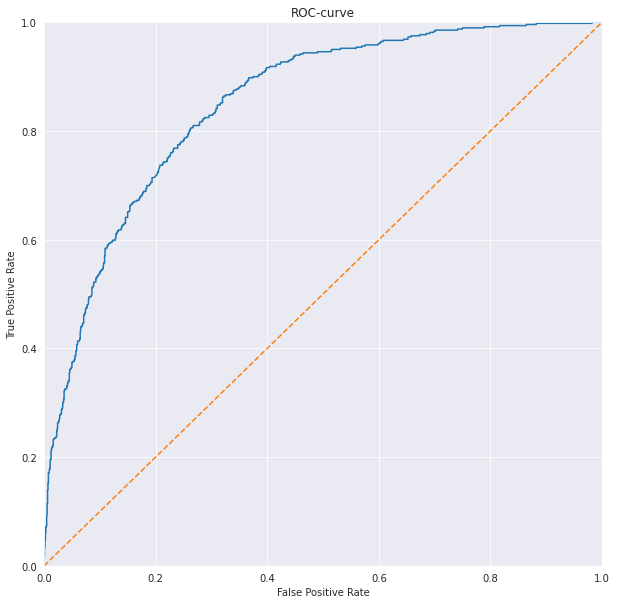

AUC: 0.8494775907946548


In [137]:
fpr, tpr, thresholds = roc_curve(y_test, prediction) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

The results have improved, relative to the baseline and the result is satisfactory in quality

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### Catboost tuning

Likewise, let's test for `Catboost`

In [138]:
cat_features

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'contract',
 'paperless_billing',
 'payment_method',
 'loyality']

In [139]:
def objective(trial,data=X_train,target=y_train):
    
    X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(X_train, y_train, test_size=0.25,
                                                        random_state=42)
    params_space = {

        
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
        'objective': 'Logloss',
        'depth': trial.suggest_int('depth', 2, 9),
        'boosting_type': 'Ordered',
        'bootstrap_type': 'MVS',
        'l2_leaf_reg': 1,
        'n_estimators': 200,
        'learning_rate':trial.suggest_float('learning_rate', 0.1, 0.4)
    }


    train_data = Pool(data=X_train_cat, 
                  label=y_train_cat,
                  cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)

    model = CatBoostClassifier(**params_space, random_seed=42, verbose=False)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    preds = model.predict_proba(X_valid_cat)[:, 1]
    auc = roc_auc_score(y_valid_cat, preds, average ='macro')
    return auc


In [140]:
%%capture
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, timeout=600)
print('Number of completed tests:', len(study.trials))
print('Best Trial:', study.best_trial.params)

[I 2021-09-27 10:21:52,804] A new study created in memory with name: no-name-4d7056ba-1f8a-4523-90ca-1f9e968157c0
[I 2021-09-27 10:21:53,600] Trial 0 finished with value: 0.8515503128669832 and parameters: {'colsample_bylevel': 0.7293678423251134, 'depth': 2, 'learning_rate': 0.2969891536590543}. Best is trial 0 with value: 0.8515503128669832.
[I 2021-09-27 10:21:54,855] Trial 1 finished with value: 0.8507513481616508 and parameters: {'colsample_bylevel': 0.5163991587795207, 'depth': 4, 'learning_rate': 0.24968174246300195}. Best is trial 0 with value: 0.8515503128669832.
[I 2021-09-27 10:21:59,576] Trial 2 finished with value: 0.8481923240963081 and parameters: {'colsample_bylevel': 0.5177144942677498, 'depth': 9, 'learning_rate': 0.18876436952069167}. Best is trial 0 with value: 0.8515503128669832.
[I 2021-09-27 10:22:05,617] Trial 3 finished with value: 0.8519169310407282 and parameters: {'colsample_bylevel': 0.9591048410908254, 'depth': 9, 'learning_rate': 0.2606231744945521}. Best

In [141]:
optuna.visualization.plot_optimization_history(study)

In [142]:
params_cat_2 = study.best_trial.params

In [143]:
%%time
start = time.time()

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)


test_data = Pool(data=X_test,
                 cat_features=cat_features)
scores = []
prediction = np.zeros(X_test.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
    X_train_cat, X_valid_cat = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_cat, y_valid_cat = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_data = Pool(data=X_train_cat, 
                      label=y_train_cat,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params_cat_2, 
                               loss_function='Logloss',
                               eval_metric='AUC',
                               random_seed=42, 
                               verbose=200)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
end = time.time()
elapsed = end - start

0:	test: 0.7930570	best: 0.7930570 (0)	total: 4.36ms	remaining: 4.36s
200:	test: 0.8236671	best: 0.8440354 (27)	total: 834ms	remaining: 3.31s
400:	test: 0.8211090	best: 0.8440354 (27)	total: 1.64s	remaining: 2.45s
600:	test: 0.8190495	best: 0.8440354 (27)	total: 2.46s	remaining: 1.64s
800:	test: 0.8163274	best: 0.8440354 (27)	total: 3.28s	remaining: 815ms
999:	test: 0.8152100	best: 0.8440354 (27)	total: 4.1s	remaining: 0us

bestTest = 0.8440354263
bestIteration = 27

Shrink model to first 28 iterations.
0:	test: 0.8066143	best: 0.8066143 (0)	total: 4.13ms	remaining: 4.12s
200:	test: 0.8392331	best: 0.8526103 (31)	total: 807ms	remaining: 3.21s
400:	test: 0.8314686	best: 0.8526103 (31)	total: 1.62s	remaining: 2.42s
600:	test: 0.8275251	best: 0.8526103 (31)	total: 2.44s	remaining: 1.62s
800:	test: 0.8235540	best: 0.8526103 (31)	total: 3.26s	remaining: 810ms
999:	test: 0.8199153	best: 0.8526103 (31)	total: 4.09s	remaining: 0us

bestTest = 0.8526103379
bestIteration = 31

Shrink model to fi

In [144]:
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(model.__class__.__name__)+str(' ')+str('Optuna')))

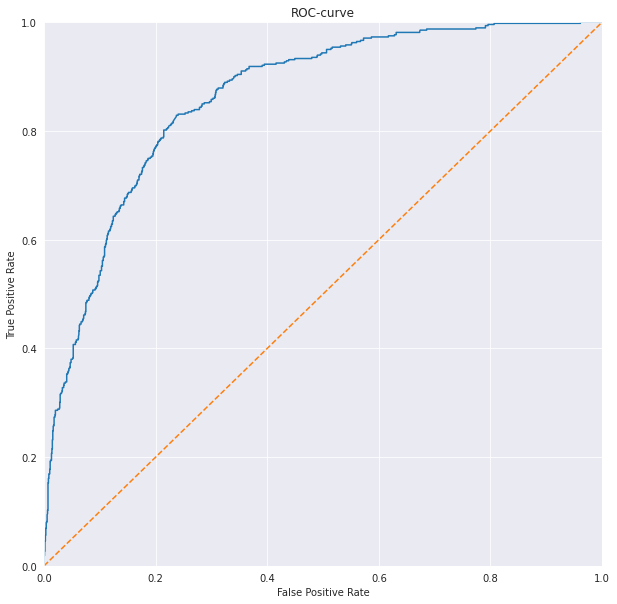

AUC: 0.8622259712935489


In [145]:
fpr, tpr, thresholds = roc_curve(y_test, prediction)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

The results improved, relative to the baseline, but it is not the best. It is worth noting that the model generalizes well

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### Stacking

Let's try to improve the results using the stacking technique. As models, we will take those that we used earlier, we will make a shallow neural network as a meta-student.

In [146]:
def create_baseline():

	model = Sequential()
	model.add(Dense(8, input_dim=4, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', 
               optimizer=Nadam(lr=0.0001), 
               metrics=['accuracy'])
	return model

In [147]:
blender = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=8, verbose=0)

In [148]:
%%time
%%capture
start = time.time()
X_train_st, X_val_st, y_train_st, y_val_st = train_test_split(
        X_train_prep, y_train, test_size=0.25, random_state=42)
X, X_val_eval, y, y_val_eval = train_test_split(X_train_st, y_train_st, 
                                                test_size=0.20,
                                                random_state=42)
classes_weights = class_weight.compute_sample_weight(
                  class_weight='balanced',
                  y = y)

XGB_1 = XGBClassifier(random_state=42, eval_metric ='logloss',
                      sample_weight=classes_weights)
XGB_2 = XGBClassifier(**params_XGB, random_state=42, eval_metric ='logloss',
                      sample_weight=classes_weights)
CAT_1 = CatBoostClassifier(**params_cat)
CAT_2 = CatBoostClassifier(**params_cat_2)
estimators = [XGB_1, XGB_2, CAT_1, CAT_2]
# training models to build a meta-student training set
for estimator in estimators:
    print('Обучение', estimator)

    estimator.fit(X, y, eval_set=[(X_val_eval, y_val_eval)], verbose=200)

X_val_predictions = np.empty((X_val_st.shape[0], len(estimators)), dtype=np.float32)
# collecting a set of prediction models
for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict_proba(X_val_st)[:, 1]

# teach the meta-student
blender.fit(X_val_predictions, y_val_st)

end = time.time()
elapsed = end - start

Learning rate set to 0.042131
0:	test: 0.7508828	best: 0.7508828 (0)	total: 2.16ms	remaining: 2.15s
200:	test: 0.8439733	best: 0.8527629 (41)	total: 592ms	remaining: 2.35s
400:	test: 0.8318521	best: 0.8527629 (41)	total: 1.16s	remaining: 1.73s
600:	test: 0.8270308	best: 0.8527629 (41)	total: 1.73s	remaining: 1.15s
800:	test: 0.8238477	best: 0.8527629 (41)	total: 2.3s	remaining: 571ms
999:	test: 0.8207750	best: 0.8527629 (41)	total: 2.84s	remaining: 0us

bestTest = 0.8527629234
bestIteration = 41

Shrink model to first 42 iterations.
0:	learn: 0.5675475	test: 0.5717522	best: 0.5717522 (0)	total: 2.38ms	remaining: 2.38s
200:	learn: 0.2242826	test: 0.4527045	best: 0.4062270 (18)	total: 455ms	remaining: 1.81s
400:	learn: 0.1463255	test: 0.5036974	best: 0.4062270 (18)	total: 920ms	remaining: 1.37s
600:	learn: 0.1027792	test: 0.5548369	best: 0.4062270 (18)	total: 1.39s	remaining: 920ms
800:	learn: 0.0761478	test: 0.5950302	best: 0.4062270 (18)	total: 1.85s	remaining: 459ms
999:	learn: 0.0595

2021-09-27 10:22:54.334886: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-27 10:22:54.338218: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-27 10:22:54.338262: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-27 10:22:54.338298: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ef4a84ca508a): /proc/driver/nvidia/version does not exist
2021-09-27 10:22:54.339502: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

CPU times: user 37.3 s, sys: 6.17 s, total: 43.5 s
Wall time: 22.7 s


In [149]:
start_pred = time.time()

X_test_predictions = np.empty((X_test.shape[0], len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict_proba(X_test_prep)[:, 1]

y_pred = blender.predict_proba(X_test_predictions)[:, 1]
end_pred = time.time()
elapsed_pred = end_pred - start_pred

In [150]:
auc.append(roc_auc_score(y_test, y_pred, average ='macro'))
y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(blender.__class__.__name__)+str(' ')+str('Stacking')))

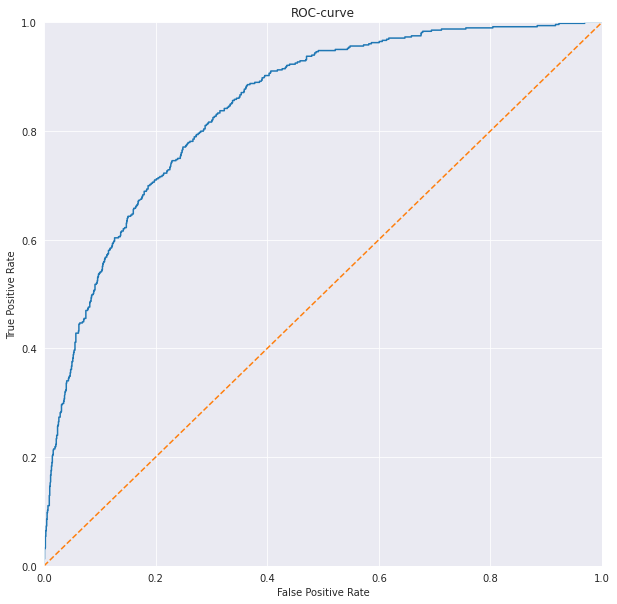

AUC: 0.8442445422242777


In [151]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred, average ='macro'))

The results are acceptable in quality, but not the best - let's try to set up a meta-student. Models have already been tuned before

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### Stacking keras tuner

Let's try to tune `Blender` with` Keras Tuner`

In [152]:
def build_model(hp):
  model = Sequential()
  activation_choice = hp.Choice('activation', values=['relu', 'selu', 'elu'])
  model.add(Dense(units=hp.Int('units_input',    
                                  min_value=4,    
                                  max_value=32,   
                                  step=2),  
                  input_dim=X_val_predictions.shape[1], activation=activation_choice))
  model.add(Dense(units=hp.Int('units_input',    
                              min_value=4,    
                              max_value=32,   
                              step=2),  
                  input_dim=X_val_predictions.shape[1], activation=activation_choice))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', 
                optimizer=Nadam(lr=0.001), 
                metrics=['accuracy'])
  return model

In [153]:
tuner = RandomSearch(
    build_model,                 
    objective='loss',    
                        
    max_trials=10,                
    directory='test_directory_01',
    overwrite=True   
    )


early_stopping = EarlyStopping(

    mode='min', 
    patience=20,
    restore_best_weights=True,
)

In [154]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu', 'elu'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 32, 'step': 2, 'sampling': None}


In [155]:
tuner.search(X_val_predictions, y_val_st,           
             batch_size=4,           
             epochs=20, validation_split=0.25
             )

Trial 10 Complete [00h 00m 11s]
loss: 0.4318064749240875

Best loss So Far: 0.43046697974205017
Total elapsed time: 00h 01m 51s


In [156]:
models = tuner.get_best_models(num_models=2)

We got the best parameters from the search - we will form a new model and try to start training again

In [157]:
for model in models:
  model.summary()
  model.evaluate(X_val_predictions, y_val_st)
  print()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 1,111
Trainable params: 1,111
Non-trainable params: 0
_________________________________________________________________
42/42 [==============================] - 0s 1ms/step - loss: 0.4162 - accuracy: 0.7977

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 22)                110       
_________________________________________________________________
dense_1 (Den

In [158]:
def create_baseline():

	model = Sequential()
	model.add(Dense(22, input_dim=4, activation='selu'))
	model.add(Dense(22, activation='selu'))
	model.add(Dense(1, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', 
								optimizer=Nadam(lr=0.001), 
								metrics=['accuracy'])
	return model

In [159]:
blender = KerasClassifier(build_fn=create_baseline, epochs=50, batch_size=4, verbose=0)

In [160]:
%%time
%%capture
start = time.time()
X_train_st, X_val_st, y_train_st, y_val_st = train_test_split(
        X_train_prep, y_train, test_size=0.25, random_state=42)
X, X_val_eval, y, y_val_eval = train_test_split(X_train_st, y_train_st, 
                                                test_size=0.20,
                                                random_state=42)
classes_weights = class_weight.compute_sample_weight(
                  class_weight='balanced',
                  y = y)

XGB_1 = XGBClassifier(random_state=42, eval_metric ='logloss',
                      sample_weight=classes_weights)
XGB_2 = XGBClassifier(**params_XGB, random_state=42, eval_metric ='logloss',
                      sample_weight=classes_weights)
CAT_1 = CatBoostClassifier(**params_cat)
CAT_2 = CatBoostClassifier(**params_cat_2, 
                               loss_function='Logloss',
                              eval_metric='AUC',
                               random_seed=42, 
                               verbose=200)
estimators = [XGB_1, XGB_2, CAT_1, CAT_2]
for estimator in estimators:
    print('Обучение', estimator)

    estimator.fit(X, y, eval_set=[(X_val_eval, y_val_eval)], verbose=200)

X_val_predictions = np.empty((X_val_st.shape[0], len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict_proba(X_val_st)[:, 1]


blender.fit(X_val_predictions, y_val_st)

end = time.time()
elapsed = end - start

Learning rate set to 0.042131
0:	test: 0.7508828	best: 0.7508828 (0)	total: 2.3ms	remaining: 2.3s
200:	test: 0.8439733	best: 0.8527629 (41)	total: 557ms	remaining: 2.21s
400:	test: 0.8318521	best: 0.8527629 (41)	total: 1.17s	remaining: 1.74s
600:	test: 0.8270308	best: 0.8527629 (41)	total: 1.78s	remaining: 1.18s
800:	test: 0.8238477	best: 0.8527629 (41)	total: 2.35s	remaining: 585ms
999:	test: 0.8207750	best: 0.8527629 (41)	total: 2.94s	remaining: 0us

bestTest = 0.8527629234
bestIteration = 41

Shrink model to first 42 iterations.
0:	test: 0.7601350	best: 0.7601350 (0)	total: 2.12ms	remaining: 2.12s
200:	test: 0.8122825	best: 0.8433707 (10)	total: 472ms	remaining: 1.88s
400:	test: 0.8064214	best: 0.8433707 (10)	total: 963ms	remaining: 1.44s
600:	test: 0.8021772	best: 0.8433707 (10)	total: 1.45s	remaining: 962ms
800:	test: 0.7986546	best: 0.8433707 (10)	total: 1.93s	remaining: 480ms
999:	test: 0.7992658	best: 0.8433707 (10)	total: 2.41s	remaining: 0us

bestTest = 0.8433706816
bestItera

In [161]:
start_pred = time.time()

X_test_predictions = np.empty((X_test.shape[0], len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict_proba(X_test_prep)[:, 1]

y_pred = blender.predict_proba(X_test_predictions)[:, 1]
end_pred = time.time()
elapsed_pred = end_pred - start_pred

In [162]:
auc.append(roc_auc_score(y_test, y_pred, average ='macro'))
y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(blender.__class__.__name__)+str(' ')+str('KerasTuner')))

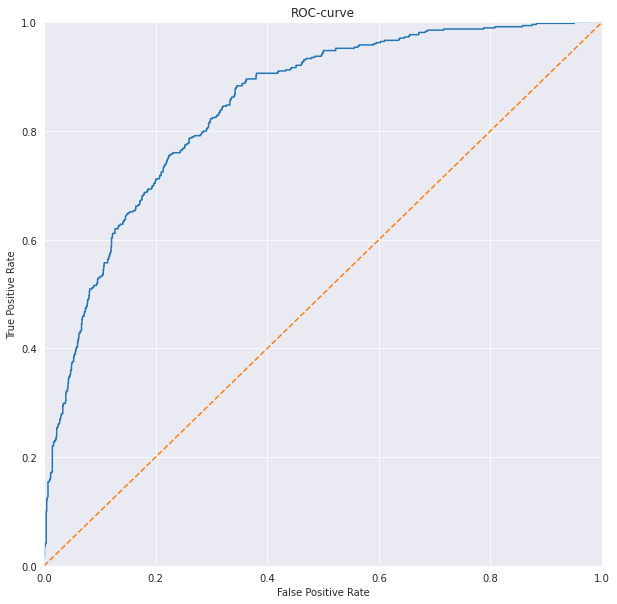

AUC: 0.8455530079240748


In [163]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred, average ='macro'))

Unfortunately, it was not possible to greatly improve the results relative to the overall picture, but better than in the base case

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### Upsampling

Let's try the upsampling technique. This will allow us to balance the set by the number of tags.

In [164]:
train, valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=42)

def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled = shuffle(features_upsampled, random_state=42)
    target_upsampled = shuffle(target_upsampled, random_state=42)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(train, target_train, 3)

print(features_upsampled.shape)
print(target_upsampled.shape)

(8062, 20)
(8062,)


The best balance is obtained using a resampling factor of `3`

In [165]:
target_upsampled.value_counts(normalize=True)

1    0.517241
0    0.482759
Name: label, dtype: float64

In [166]:
%%time
start = time.time()

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

params_cat = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 42
         }

test_data = Pool(data=valid,
                 cat_features=cat_features)
scores = []
prediction = np.zeros(X_test.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(features_upsampled, target_upsampled)):
    X_train_cat, X_valid_cat = features_upsampled.iloc[train_index], features_upsampled.iloc[valid_index]
    y_train_cat, y_valid_cat = target_upsampled.iloc[train_index], target_upsampled.iloc[valid_index]
    
    train_data = Pool(data=X_train_cat, 
                      label=y_train_cat,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params_cat)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
end = time.time()
elapsed = end - start

Learning rate set to 0.050217
0:	test: 0.8005344	best: 0.8005344 (0)	total: 8.04ms	remaining: 8.04s
200:	test: 0.8711200	best: 0.8711200 (200)	total: 1.39s	remaining: 5.53s
400:	test: 0.8866121	best: 0.8866121 (400)	total: 2.83s	remaining: 4.22s
600:	test: 0.8978684	best: 0.8980515 (597)	total: 4.28s	remaining: 2.84s
800:	test: 0.9086890	best: 0.9086890 (800)	total: 5.77s	remaining: 1.43s
999:	test: 0.9170084	best: 0.9170084 (999)	total: 7.23s	remaining: 0us

bestTest = 0.9170083702
bestIteration = 999

Learning rate set to 0.050217
0:	test: 0.8267255	best: 0.8267255 (0)	total: 7.89ms	remaining: 7.89s
200:	test: 0.8789500	best: 0.8789500 (200)	total: 1.38s	remaining: 5.49s
400:	test: 0.8965369	best: 0.8966108 (396)	total: 2.94s	remaining: 4.39s
600:	test: 0.9074491	best: 0.9074491 (600)	total: 4.4s	remaining: 2.92s
800:	test: 0.9169884	best: 0.9169884 (800)	total: 5.88s	remaining: 1.46s
999:	test: 0.9233776	best: 0.9233776 (999)	total: 7.33s	remaining: 0us

bestTest = 0.9233776009
best

In [167]:
auc.append(roc_auc_score(target_valid, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(target_valid, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed)
model_name.append((str(model.__class__.__name__)+str(' ')+str('CV-Upsampling')))

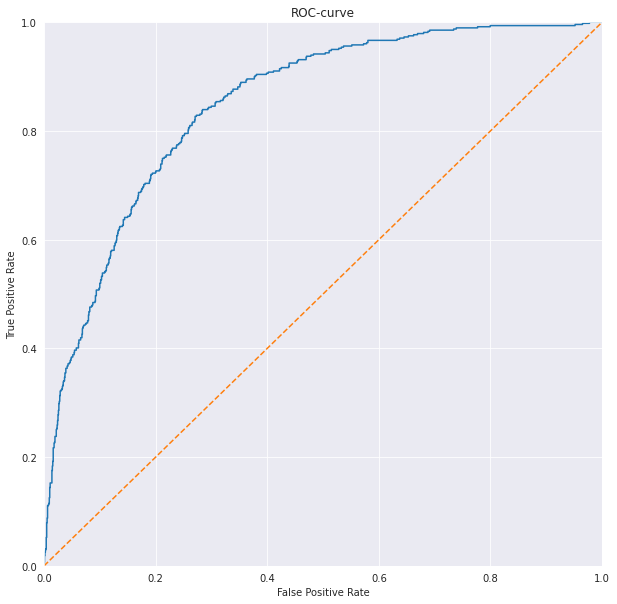

AUC: 0.8488685476437847


In [168]:
fpr, tpr, thresholds = roc_curve(y_test, prediction) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

Let's try to configure. The model is poorly generalized - significant retraining is underway - but one way or another - the result is high

In [169]:
def objective(trial,data=X_train,target=y_train):
    
    X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(features_upsampled, 
                                                                          target_upsampled, 
                                                                          test_size=0.25,
                                                                           random_state=42)
    params_space = {

        
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
        'objective': 'Logloss',
        'depth': trial.suggest_int('depth', 2, 9),
        'boosting_type': 'Ordered',
        'bootstrap_type': 'MVS',
        'l2_leaf_reg': 1,
        'n_estimators': 1000,
        'learning_rate':trial.suggest_float('learning_rate', 0.1, 0.4)
    }


    train_data = Pool(data=X_train_cat, 
                  label=y_train_cat,
                  cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                  label=y_valid_cat,
                  cat_features=cat_features)

    model = CatBoostClassifier(**params_space, random_seed=42, verbose=False)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    preds = model.predict_proba(X_valid_cat)[:, 1]
    auc = roc_auc_score(y_valid_cat, preds, average ='macro')
    return auc


In [170]:
%%capture
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, timeout=600)
print('Number of completed tests:', len(study.trials))
print('Best Trial:', study.best_trial.params)

[I 2021-09-27 10:26:07,567] A new study created in memory with name: no-name-ad6d22f8-5593-4ca4-aa79-fa28612421eb


[10:18:35] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:19:58] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:18:35] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:19:58] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:18:35] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:19:36] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:19:58] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above case

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encode

[10:18:35] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:19:58] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:21:02] WARNING: ../src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above case

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-09-27 10:26:19,462] Trial 0 finished with value: 0.8892199678002236 and parameters: {'colsam

In [171]:
optuna.visualization.plot_optimization_history(study)

In [172]:
params_cat_2 = study.best_trial.params

In [173]:
%%time
start = time.time()

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)


test_data = Pool(data=X_test,
                 cat_features=cat_features)
scores = []
prediction = np.zeros(X_test.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
    X_train_cat, X_valid_cat = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_cat, y_valid_cat = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_data = Pool(data=X_train_cat, 
                      label=y_train_cat,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params_cat_2, 
                               loss_function='Logloss',
                               eval_metric='AUC',
                               random_seed=42, 
                               verbose=200,
                               boosting_type='Ordered',
                               bootstrap_type='MVS',
                               l2_leaf_reg= 1,
                               n_estimators= 1000)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
end = time.time()
elapsed = end - start

0:	test: 0.7892220	best: 0.7892220 (0)	total: 20.8ms	remaining: 20.8s
200:	test: 0.8429918	best: 0.8506986 (42)	total: 3.15s	remaining: 12.5s
400:	test: 0.8395540	best: 0.8506986 (42)	total: 6.69s	remaining: 9.99s
600:	test: 0.8395771	best: 0.8506986 (42)	total: 10.4s	remaining: 6.9s
800:	test: 0.8376423	best: 0.8506986 (42)	total: 14.2s	remaining: 3.52s
999:	test: 0.8369174	best: 0.8506986 (42)	total: 17.8s	remaining: 0us

bestTest = 0.8506986452
bestIteration = 42

Shrink model to first 43 iterations.
0:	test: 0.8168769	best: 0.8168769 (0)	total: 19.8ms	remaining: 19.8s
200:	test: 0.8384804	best: 0.8507771 (33)	total: 3.14s	remaining: 12.5s
400:	test: 0.8369774	best: 0.8507771 (33)	total: 6.45s	remaining: 9.64s
600:	test: 0.8348856	best: 0.8507771 (33)	total: 10.1s	remaining: 6.68s
800:	test: 0.8324244	best: 0.8507771 (33)	total: 13.7s	remaining: 3.4s
999:	test: 0.8290028	best: 0.8507771 (33)	total: 17.2s	remaining: 0us

bestTest = 0.8507771447
bestIteration = 33

Shrink model to fir

In [174]:
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(model.__class__.__name__)+str(' ')+str('Optuna-Upsampling')))

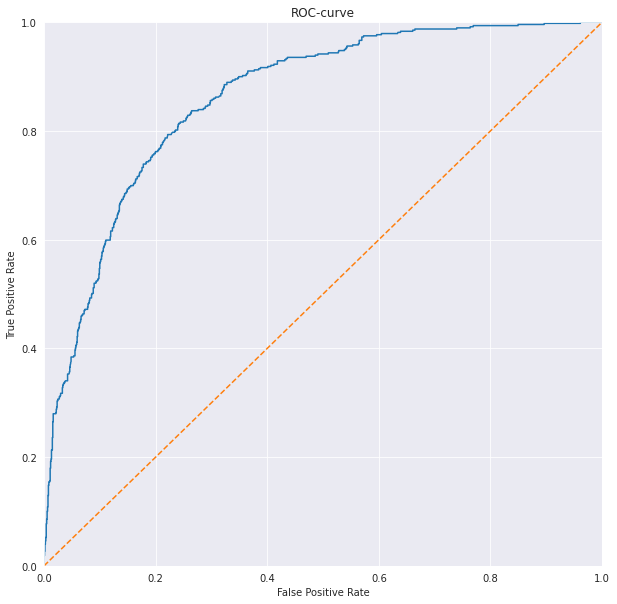

AUC: 0.8609069206192047


In [175]:
fpr, tpr, thresholds = roc_curve(y_test, prediction)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

We got a very good result. Best so far


<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### Ensemble of Logistic Regression, Random Forest and SVC

Let's try ensemble prediction, set the voting type to soft. We will use `Logistic regression`,` Random forest` and `SVC support vectors`

In [176]:
log_clf = LogisticRegression(solver="liblinear", random_state=42,
                            class_weight='balanced', max_iter=500)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42, 
                            class_weight='balanced')
svm_clf = SVC(gamma="auto", probability=True, random_state=42, 
                            class_weight='balanced')

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), 
                ('svc', svm_clf)],
    voting='soft')


start = time.time()
voting_clf.fit(X_train_prep, y_train)
end = time.time()
elapsed = end - start


In [177]:
start_pred = time.time()
predict = voting_clf.predict_proba(X_test_prep)[:, 1]
end_pred = time.time()
elapsed_pred = end_pred - start_pred

In [178]:
auc.append(roc_auc_score(y_test, predict, average ='macro'))
y_bin = (predict >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(voting_clf.__class__.__name__)))

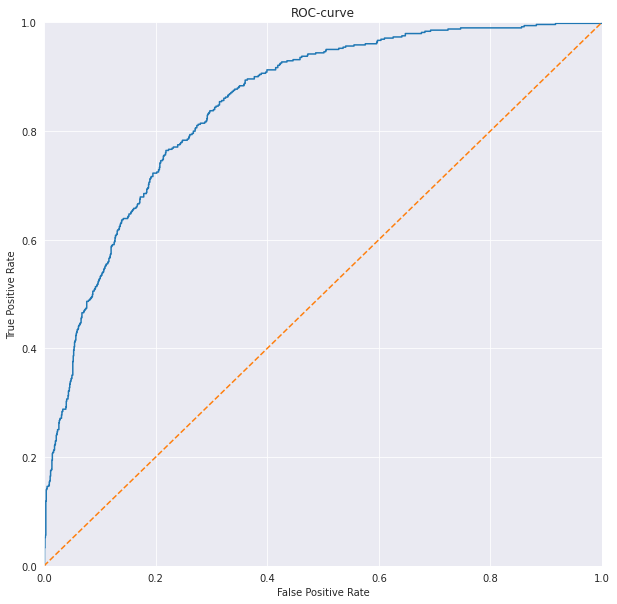

AUC: 0.8486926742205388


In [179]:
fpr, tpr, thresholds = roc_curve(y_test, predict) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_test, predict, average ='macro'))

Unfortunately, the results are not the best. We will not adjust the ensemble - there are simpler ways to get the required metric

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

<a id='shap'></a>

### Creation of additional characteristics and training without the least important

Let's try to define an additional category - only an Internet user or only a phone user, or another user - for example, only television

In [180]:
X_train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,loyality
6607,Male,0,No,Yes,1,No,No,1,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,25.30,0
2598,Female,0,No,No,7,Yes,No,1,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,75.15,0
2345,Female,0,No,Yes,4,Yes,No,0,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),20.05,0
4093,Female,0,No,No,29,Yes,Yes,1,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),76.00,0
693,Female,0,No,No,3,Yes,Yes,1,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),75.10,0


In [181]:
def users_bin (data):

    if data['internet_service'] == 1 and data['multiple_lines']=='Yes':
        return 0
    elif data['internet_service'] == 1:
        return 1
    elif data['multiple_lines']=='Yes':
        return 2
    else:
        return 3

In [182]:
X_train['user_cat'] = X_train.apply(users_bin, axis=1)
X_test['user_cat'] = X_test.apply(users_bin, axis=1)

Let's remove from the training sample the features that were not included in the best

In [183]:
cols_del = list(set(X_train.columns) - set(save_best))

In [184]:
cols_del

['streaming_tv',
 'multiple_lines',
 'gender',
 'partner',
 'dependents',
 'device_protection',
 'online_backup',
 'user_cat']

In [185]:
X_train.drop(cols_del, axis=1, inplace=True
             )
X_test.drop(cols_del, axis=1, inplace=True
             )
cat_features = list(X_train.select_dtypes(include=['object', 'category']).columns)

Let's try to train a model with a new feature

In [186]:
params_cat_2 = study.best_trial.params

In [187]:
%%time
%%capture
start = time.time()

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)


test_data = Pool(data=X_test,
                 cat_features=cat_features)
scores = []
prediction = np.zeros(X_test.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
    X_train_cat, X_valid_cat = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_cat, y_valid_cat = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_data = Pool(data=X_train_cat, 
                      label=y_train_cat,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params_cat_2, 
                               loss_function='Logloss',
                              eval_metric='AUC',
                               random_seed=42, 
                               verbose=200)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
end = time.time()
elapsed = end - start

0:	test: 0.8161566	best: 0.8161566 (0)	total: 7.16ms	remaining: 7.16s
200:	test: 0.8320920	best: 0.8397618 (25)	total: 1.34s	remaining: 5.33s
400:	test: 0.8273243	best: 0.8397618 (25)	total: 2.73s	remaining: 4.09s
600:	test: 0.8202778	best: 0.8397618 (25)	total: 4.15s	remaining: 2.75s
800:	test: 0.8173826	best: 0.8397618 (25)	total: 5.56s	remaining: 1.38s
999:	test: 0.8161958	best: 0.8397618 (25)	total: 6.97s	remaining: 0us

bestTest = 0.8397618234
bestIteration = 25

Shrink model to first 26 iterations.
0:	test: 0.8237549	best: 0.8237549 (0)	total: 11.2ms	remaining: 11.2s
200:	test: 0.8309168	best: 0.8493203 (20)	total: 1.41s	remaining: 5.59s
400:	test: 0.8269595	best: 0.8493203 (20)	total: 2.8s	remaining: 4.19s
600:	test: 0.8230807	best: 0.8493203 (20)	total: 4.21s	remaining: 2.8s
800:	test: 0.8231315	best: 0.8493203 (20)	total: 5.63s	remaining: 1.4s
999:	test: 0.8236394	best: 0.8493203 (20)	total: 7.02s	remaining: 0us

bestTest = 0.849320287
bestIteration = 20

Shrink model to first

In [188]:
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(model.__class__.__name__)+str(' ')+str('New_feature_shap')))

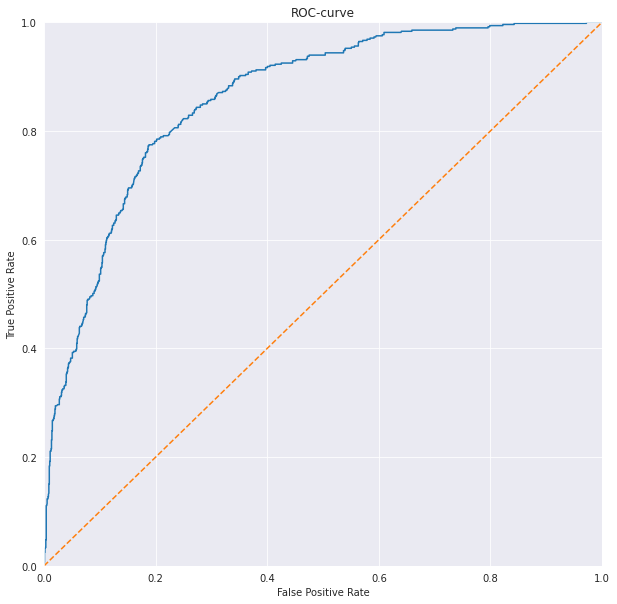

AUC: 0.8608670234074498


In [189]:
fpr, tpr, thresholds = roc_curve(y_test, prediction)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

Unfortunately, the result has not improved significantly again. But it also did not get much worse - it is still acceptable - and this is with a decrease in the number of signs by almost half

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

### Sanity check. DummyClassifier

Let's try the `stratified` strategy,` 1` is important to us - they talk about churn, predicting churn 1 for everyone as a constant will entail losses for the company, predicting `0` - we will not predict churn. Or just predict `0` and` 1` with probability `0.5`. Indirectly, through the `ROC-AUC`, we have already checked the performance of our models - we will make an additional check

In [190]:
start = time.time()
model = DummyClassifier(strategy='stratified')
model.fit(X_train_prep, y_train)

end = time.time()
elapsed = end - start

In [191]:
start_pred = time.time()
y_pred = model.predict_proba(X_test_prep)[:, 1]

end_pred = time.time()
elapsed_pred = end_pred - start_pred

auc.append(roc_auc_score(y_test, y_pred, average ='macro'))
y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_pred))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(model.__class__.__name__)+str(' ')+str('stratified')))

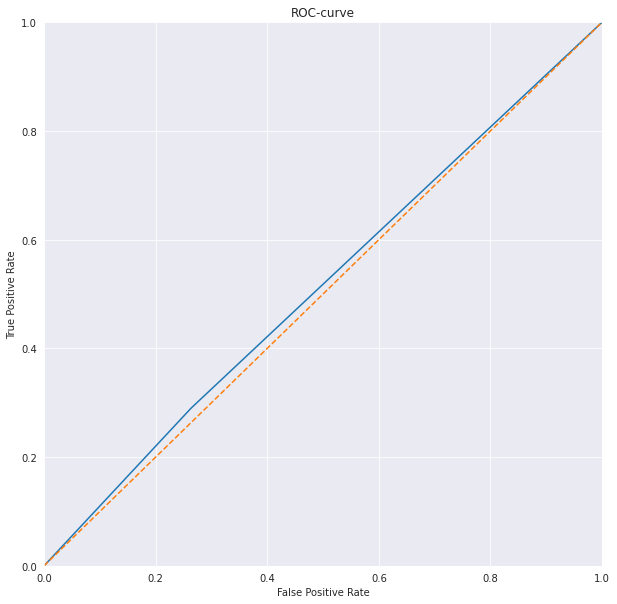

AUC: 0.5132686727093301


In [192]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred, average ='macro'))

We got a quite expected option - `AUC` is close to` 0.5` - it could have been omitted - but for the interpretation of `ROC-AUC` they made an additional model

<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___

## Conclusion

For convenience, we will display a pivot table

In [194]:
summary = pd.DataFrame({ 
    'model' : model_name , 
    'training_time, sec' : training_time ,
    'prediction_time, sec' : prediction_time , 
    'AUC' : auc,
    'Accuracy': accuracy}
    ).sort_values(by='AUC', ascending=False).reset_index(drop=True)





summary.style.highlight_max( 'AUC' , color = 'green' , axis = 0 )

,model,"training_time, sec","prediction_time, sec",AUC,Accuracy
0,CatBoostClassifier Optuna,21.475704,0.014256,0.862226,0.801249
1,CatBoostClassifier Optuna-Upsampling,86.271697,0.365548,0.860907,0.801817
2,CatBoostClassifier New_feature_shap,36.256761,0.500937,0.860867,0.798978
3,CatBoostClassifier CV,27.211940,27.211940,0.860666,0.802385
4,CatBoostClassifier базовый,5.642970,0.014256,0.859077,0.799546
5,LightGBM GridSearCVcategory,0.398755,0.051513,0.850098,0.757524
6,XGBClassifier Optuna,0.935927,0.935927,0.849478,0.801817
7,CatBoostClassifier CV-Upsampling,37.538746,37.538746,0.848869,0.769449
8,VotingClassifier,10.279894,0.500937,0.848693,0.781942
9,KerasClassifier KerasTuner,24.640177,0.365548,0.845553,0.801817


**The company is left most often by profitable users, which is used by:**

- electronic checks
- use a monthly payment
- do not use additional services in the form of antivirus, cloud storage, dedicated line with technical support and equipment protection
- are not married.

**The higher the monthly payment** - **the higher the likelihood of leaving**. It may be worth considering the need for incentives to move to better rates.


These studies were also confirmed by the conclusions of the models on the importance of features.
According to the results of the work, all the planned points of the plan were completed:

1. We have prepared a draft `pipeline` for loading the data set,` Pipeline` for processing features - this will allow us to automate the process of processing new information in the future. Pipeline preparation of features allows coding categorical variables, standardizing quantitative ones, due to their not normally distributed nature.

2. Faced class imbalance - fixed this problem by using weighting during training, apply cross-validation with stratified division of the sample, also worked the `Upsampling` technique

3. Created an additional feature - the number of days as a client. They did not take the start and end date - to reduce the likelihood of `Data leaks`. Measurements of mutual information showed that the new feature has `0.3n` of mutual information and will be acceptable for processing. We also added user clusters depending on the size of the monthly payment.

4. A strong correlation was found between the number of days and the total payments - the attribute `total_charges` - has been removed

5. We found out that by removing the following attributes `user_cat`,` streaming_tv`, `online_backup`,` senior_citizen`, `device_protection`,` dependents`, `partner`,` internet_service` - it is possible to get a sufficiently high result. This will reduce the time for collecting information.


<a href="#footer">Back to content</a>
<footer id="footer"></footer>

___